In [2]:
#import array_to_latex as a2l
import control as clt
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import scipy as sci

sy.init_printing()

# Cad=symbols('Cad')
# Rad=symbols('Rad')
# Cvd=symbols('Cvd')
# Rvd=symbols('Rvd')
# Ccp=symbols('Ccp')
# Rcp=symbols('Rcp')
# Lcp=symbols('Lcp')
# Cae=symbols('Cae')
# Rae=symbols('Rae')
# Cve=symbols('Cve')
# Rve=symbols('Rve')
# Ccs=symbols('Ccs')
# Rcs=symbols('Rcs')
# Lcs=symbols('Lcs')

Ccp, Lcp, Rcp = 20, 0.0001, 0.1
Ccs, Lcs, Rcs = 120, 0.0001, 0.2
Cad, Cae = 3, 2

# Definição dos parâmetros 

def Condição (R_ad, C_vd, R_vd, R_ae, C_ve, R_ve):
    Rad, Cvd, Rvd = R_ad, C_vd, R_vd
    Rae, Cve, Rve = R_ae, C_ve, R_ve
    return Rad, Cvd, Rvd, Rae, Cve, Rve

# Definição dos termos forçantes: Função das pressões

def P_a(ts, P_0, P_MAX, bpm=80):
    TR = 60/bpm
    CONT = ts % TR
    if (0.88*TR) <= CONT <= TR:
        PRES = P_0 + (P_MAX-P_0)*np.sin(np.pi*(CONT-0.88*TR)/(0.12*TR))
    else:
        PRES = P_0
    return PRES

def P_v(td,P_0, P_max, bpm=80):
    Tr = 60/bpm
    cont = td % Tr
    if 0 <= cont <= 0.2*Tr:
        Pres = P_0 + 0.5*(P_max-P_0)*(1-np.cos((np.pi*cont/(0.2*Tr))))
    elif 0.2*Tr <= cont <= 0.43*Tr:
        Pres = P_0 + 0.5*(P_max-P_0)*(1+np.cos((np.pi*(cont-0.2*Tr)/((0.43-0.2)*Tr))))
    else:
        Pres = P_0
    return Pres

def P_cp(td,P_0, P_max, bpm=80):
    Tr = 60/bpm
    cont = td % Tr
    A = 10.1
    B = P_0 + 0.5*(P_max-P_0)*(1-np.cos((2*np.pi*(0.8*Tr*0.33-0.08*Tr)/(Tr*0.33))))
    D = (np.pi*(P_max-P_0)/(0.33*Tr))*np.sin((2*np.pi*(0.8*0.33-0.4*0.2)/(0.33)))
    C =D /(A-B)
    if 0 <= cont <= 0.08*Tr:
        Pres = P_0
    elif 0.08*Tr <= cont <= 0.8*0.33*Tr:
        Pres = P_0 + 0.5*(P_max-P_0)*(1-np.cos((2*np.pi*(cont-0.08*Tr)/(Tr*0.33))))
    else:
        Pres = A + (B-A)*np.exp(-C*(cont-0.8*0.33*Tr))
    return Pres


def P_cs(td,P_0, P_max, bpm=80):
    Tr = 60/bpm
    cont = td % Tr
    r = 0.56
    u = 1.2
    K = 1.02808998
    o=(K*r+u*(K-1))/(2*K-1)
    p=1/(r+u-2*o)
    a = 0.5*(P_max-P_0)*p*np.pi/(0.2*Tr)*np.sin(p*np.pi*(u-o))
    b = P_0 + 0.5*(P_max-P_0)*(1-np.cos((p*np.pi*(r*0.2*Tr-o*0.2*Tr)/(0.2*Tr))))
    c = P_0 + 0.5*(P_max-P_0)*(1-np.cos((p*np.pi*(u*0.2*Tr-o*0.2*Tr)/(0.2*Tr))))
    if 0 <= cont <= r*0.2*Tr:
        Pres = a*(cont-r*0.2*Tr)+b
    elif r*0.2*Tr <= cont <= u*0.2*Tr:
        Pres = P_0 + 0.5*(P_max-P_0)*(1-np.cos((p*np.pi*(cont-o*0.2*Tr)/(0.2*Tr))))
    else:
        Pres = a*(cont-u*0.2*Tr)+c
    return Pres

# Função de integração para definição dos valores médios de complacência

def Compl(TC, c_vd = 15, c_vs = 0.7):
    bpm = 80
    Tl = 60/bpm
    zeit = TC % Tl
    tc = 0.2*Tl
    tr = 0.23*Tl
    if 0 <= zeit < tc:
        f = 0.5*(1-np.cos(np.pi*zeit/tc))
    elif tc <= zeit < tc + tr:
        f = 0.5*(1+np.cos(np.pi*(zeit-tc)/tr))
    else:
        f = 0
    c = 1/(1/c_vd+f*(1/c_vs-1/c_vd))
    return c

In [3]:
# Definição das matrizes do espaço de estados

def A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve):
    A=np.array([
	[-1/(Cad*Rad),1/(Rad*Cvd),0,0,0,0,-1],
	[1/(Cad*Rad),-1/(Rvd*Cvd)-1/(Rad*Cvd),0,0,1/(Rvd*Ccp),0,0],
	[0,0,-1/(Cae*Rae),1/(Rae*Cve),0,-1,0],
	[-1/(Ccs*Rve),-1/(Ccs*Rve),-1/(Ccs*Rve)+1/(Cae*Rae),-1/(Ccs*Rve)-1/(Rve*Cve)-1/(Rae*Cve),-1/(Ccs*Rve),0,0],
	[0,1/(Rvd*Cvd),0,0,-1/(Rvd*Ccp),1,0],
	[0,0,1/(Cae*Lcp),0,-1/(Ccp*Lcp),-Rcp/Lcp,0],
	[1/(Cad*Lcs)+1/(Ccs*Lcs),1/(Ccs*Lcs),1/(Ccs*Lcs),1/(Ccs*Lcs),1/(Ccs*Lcs),0,-Rcs/Lcs]])
    return A

def B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve):
    B=np.array([
    [-1/Rad,0,0],
    [1/Rad,-1/Rvd,0],
    [0,0,0],
    [0,0,-1/Rve],
    [0,1/Rvd,0],
    [0,0,0],
    [0,0,0]
    ])
    return B

def E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve):
    E=np.array([
    [-1/Rad,0,0,0, 0],
    [1/Rad,-1/Rvd,0,0, 0],
    [0,0,-1/Rae,0, 0],
    [0,0,1/Rae,-1/Rve, 1/(Ccs*Rve)],
    [0,1/Rvd,0,0, 0],
    [0,0,0,0, 0],
    [0,0,0,0, -1/(Ccs*Lcs)]
    ])
    return E

# def B_cond_ (Rad, Cvd, Rvd, Rae, Cve, Rve):
#     B=np.array([
#     [-1/Rad,0,0,0],
#     [1/Rad,-1/Rvd,0,0],
#     [0,0,0,0],
#     [0,0,0,-1/Rve],
#     [0,1/Rvd,0,0],
#     [0,0,0,0],
#     [0,0,0,0]
#     ])
#     return B

# def E_cond_ (Rad, Cvd, Rvd, Rae, Cve, Rve):
#     E=np.array([
#     [0,0,0,0],
#     [0,0,0,0],
#     [0,0,-1/Rae,0],
#     [0,0,1/Rae,0],
#     [0,0,0,0],
#     [0,0,0,0],
#     [0,0,0,0]
#     ])
#     return E

C=np.array([
    [1,0,0,0,0,0,0],
    [0,1,0,0,0,0,0],
    [0,0,0,1,0,0,0]])

D=np.array([
    [0,0,0],
    [0,0,0],
    [0,0,0]])

D0=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]])

In [4]:
# Definição do vetor de tempo do ciclo cardíaco

t_batimento = 0.75                                   # intervalo de tempo de um batimento cardíaco em segundos
steps = 100000                                       # passos
t_compl = np.linspace(0, t_batimento, steps)         

ti = 0.0375
tf = 0.15
Int = sci.integrate.quad(Compl,ti,tf)
Cm = Int[0]/(tf-ti)

q0 = 5400 

# Condição 1
Rad, Cvd, Rvd, Rae, Cve, Rve = Condição(100, 8.99, 100, 100, 5.18, 100)
A1s = A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
B1s = B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)    
E1s = E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
sys1s = clt.ss(A1s,B1s,C,D)
sys1st = clt.ss(A1s,E1s,C,D0)
Rad, Cvd, Rvd, Rae, Cve, Rve = Condição(100, 15, 100, 100, 10, 100)
A1d = A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
B1d = B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)    
E1d = E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
sys1d = clt.ss(A1d,B1d,C,D)
G1 = clt.tf(sys1s)
pp1 = clt.poles(sys1s)

# Condição 2
Rad, Cvd, Rvd, Rae, Cve, Rve = Condição(100, 1.32, 0.01, 100, 0.58, 0.02)
A2s = A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
B2s = B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)    
E2s = E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
sys2s = clt.ss(A2s,B2s,C,D)
sys2st = clt.ss(A2s,B2s,C,D)
Rad, Cvd, Rvd, Rae, Cve, Rve = Condição(100, 15, 0.01, 100, 10, 0.02)
A2d = A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
B2d = B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)    
E2d = E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
sys2d = clt.ss(A2d,B2d,C,D)
G2 = clt.tf(sys2s)
pp2 = clt.poles(sys2s)

# Condição 3
Rad, Cvd, Rvd, Rae, Cve, Rve = Condição(0.01, 15, 100, 0.02, 10, 100)
A3 = A_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
B3 = B_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)    
E3 = E_cond (Rad, Cvd, Rvd, Rae, Cve, Rve)
sys3 = clt.ss(A3,B3,C,D)
G3 = clt.tf(sys3)
pp3 = clt.poles(sys3)

In [5]:
# Matrizes de controlabilidade e respectivos postos para as 3 condições avaliadas

Q1 = clt.ctrb(A1d,B1d)
Q2 = clt.ctrb(A2d,B2d)
Q3 = clt.ctrb(A3,B3)

pQ1, pQ2, pQ3 = np.linalg.matrix_rank(Q1,tol=0.001), np.linalg.matrix_rank(Q2,tol=0.001), np.linalg.matrix_rank(Q3,tol=0.001) #Fazer observação

In [6]:
# Matrizes de observabilidade e respectivos postos para as 3 condições avaliadas

O1 = clt.obsv(A1d, C).transpose()
O2 = clt.obsv(A2d, C).transpose()
O3 = clt.obsv(A3, C).transpose()

pO1, pO2, pO3 = np.linalg.matrix_rank(O1,tol=0.01), np.linalg.matrix_rank(O2,tol=0.01), np.linalg.matrix_rank(O3,tol=0.01)

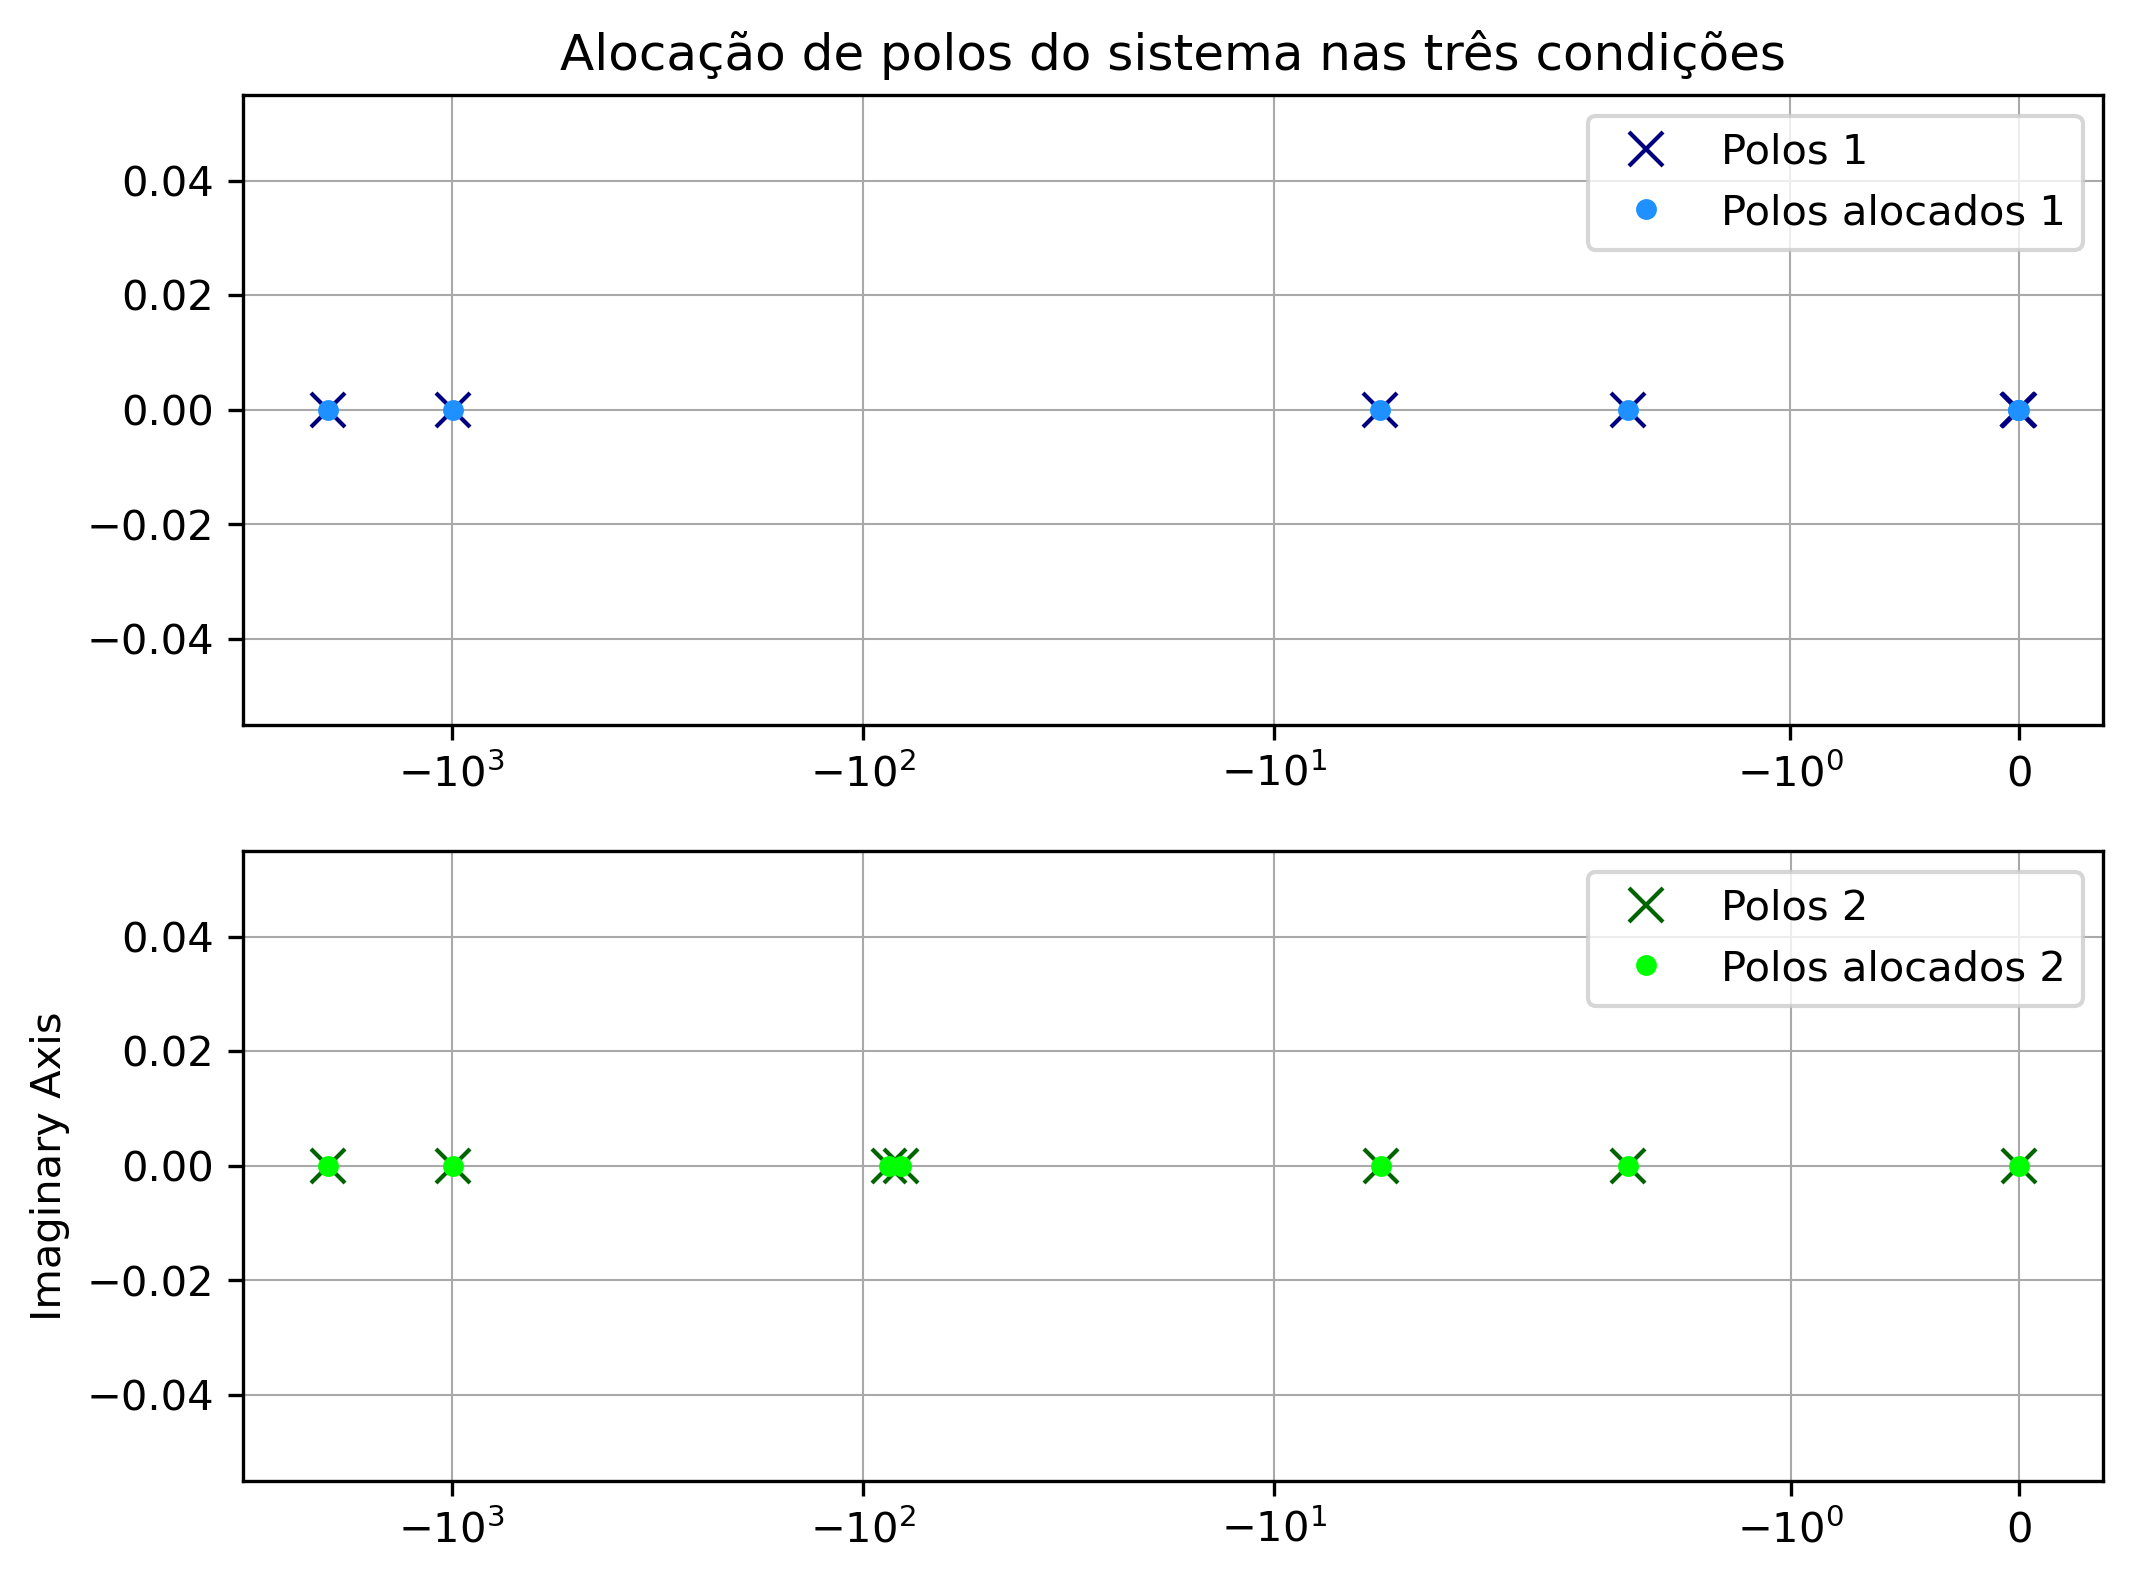

In [7]:
#Alocação dos polos  

tf1 = clt.ss2tf(A1,B1,C,D)
tf2 = clt.ss2tf(A2,B2,C,D)
tf3 = clt.ss2tf(A3,B3,C,D)

P1 = clt.StateSpace(A1, B1, C, D).poles()  
P2 = clt.StateSpace(A2, B2, C, D).poles()  
P3 = clt.StateSpace(A3, B3, C, D).poles()  

K1 = sci.signal.place_poles(A1d,B1d,pp1,method='YT').gain_matrix
K2 = sci.signal.place_poles(A2d,B2d,pp2,method='YT').gain_matrix

A1_ = A1d-np.dot(B1d,K1)
A2_ = A2d-np.dot(B2d,K2)

PA1 = clt.StateSpace(A1_, E1, C, D0).poles()  
PA2 = clt.StateSpace(A2_, E2, C, D0).poles()

#Gráfico dos polos alocados

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(P1.real, P1.imag, 'navy', marker='x', markersize = 8, lw=0)
axs[0].plot(PA1.real, PA1.imag, 'dodgerblue', marker='o', markersize = 4, lw=0)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_xscale('symlog')
axs[0].legend(['Polos 1', 'Polos alocados 1'], loc='upper right', shadow=False)
axs[0].set_title(r'Alocação de polos do sistema nas três condições', fontfamily = 'sans-serif', fontsize = 'large')

axs[1].plot(P2.real, P2.imag, 'darkgreen', marker='x',markersize = 8, lw=0)
axs[1].plot(PA2.real, PA2.imag, 'lime', marker='o', markersize = 4, lw=0)
axs[1].set_ylabel(r'Imaginary Axis')
axs[1].set_xscale('symlog')
axs[1].legend(['Polos 2','Polos alocados 2'], loc='upper right', shadow=False)
axs[1].grid(color='darkgrey', lw=0.5)

#plt.savefig('polos.png', format='png')

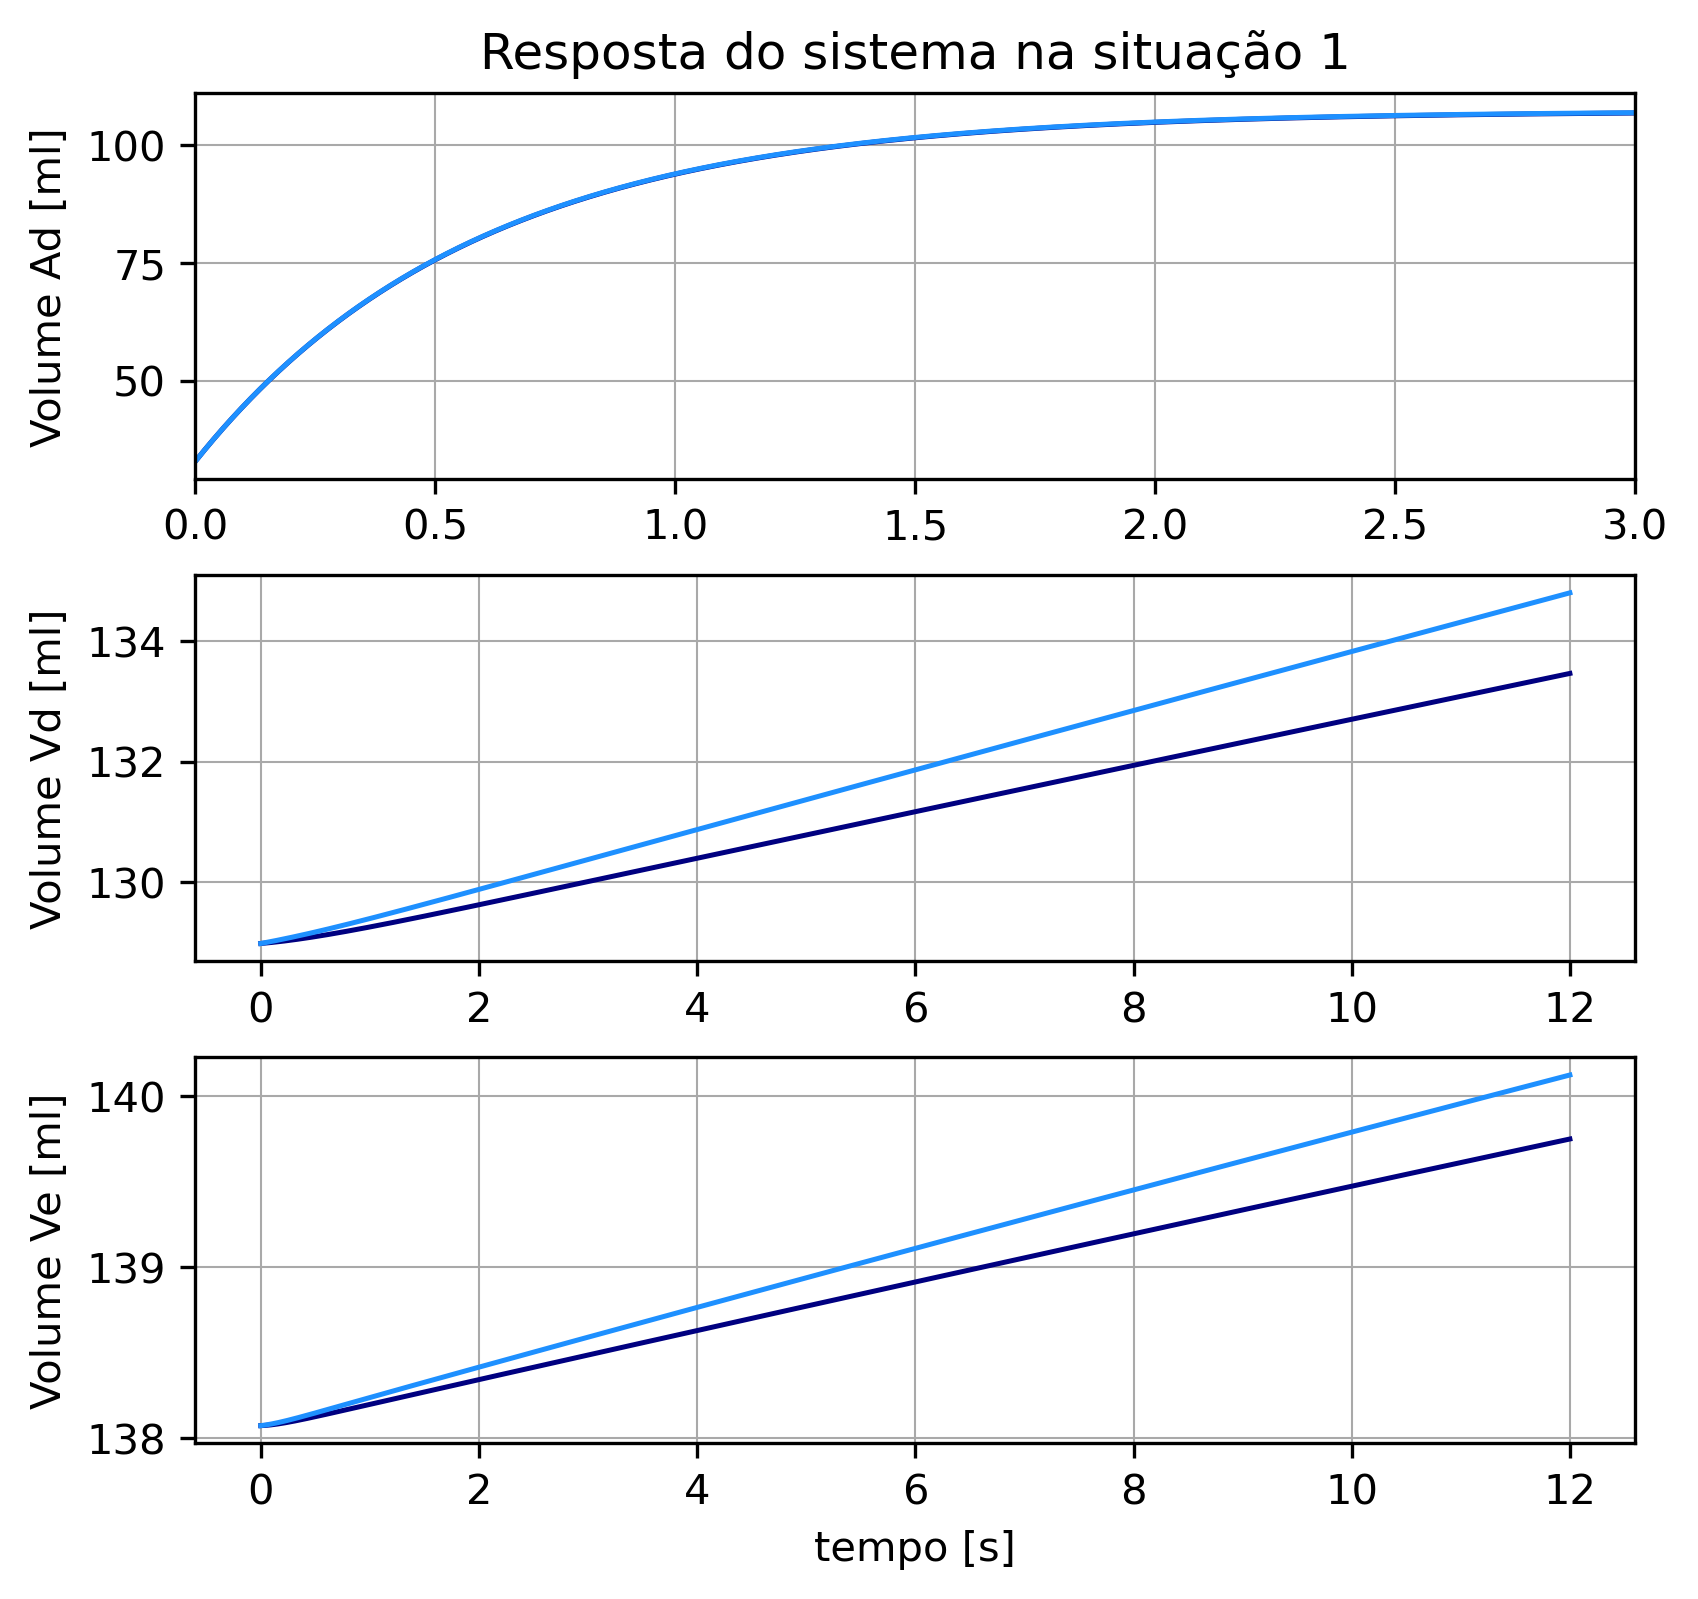

In [22]:
#Simulação inicial - Resposta à entrada degrau
                
sys1_ = clt.ss(A1_,E1,C,D0)
sys2_ = clt.ss(A2_,E2,C,D0)

steps_step = 10000
t_step = np.linspace(0, 12, steps_step)

U1_step = [np.zeros(steps_step), np.zeros(steps_step), np.zeros(steps_step), np.zeros(steps_step), q0*np.ones(steps_step)]
U2_step = [np.zeros(steps_step), np.zeros(steps_step), np.zeros(steps_step), np.zeros(steps_step), q0*np.ones(steps_step)]

X01_ = X01 = [32.8208014 ,  128.97931383,   39.65605596,  138.07347741, 687.11288571, -145.94694028, -127.52152711]
T1, out1, x1 = clt.forced_response(sys1st, T=t_step, X0=X01, U=U1_step, return_x = True)
T1_, out1_, x1_ = clt.forced_response(sys1_, T=t_step, X0=X01_, U=U1_step, return_x = True)

X02_ = X02 = [37.52059196,  129.01860359,   44.67330408,  138.12876312, 682.06349792, -118.33202057, -119.51581545]
T2, out2, x2 = clt.forced_response(sys2st, T=t_step, X0=X02, U=U2_step, return_x = True)
T2_, out2_, x2_ = clt.forced_response(sys2_, T=t_step, X0=X02_, U=U2_step, return_x = True)

# X03_ = X03 = [33.9064531 ,  116.14747051,   39.99517533,  123.84961663, 700.88055257, -150.63347473, -126.1929136 ]

#Gráficos das respostas do sistema a entradas degraus representativas

left, bottom, right, top, wspace, hspace = 0.1, 0.15, 0.7, 0.9, 0.4, 0.25

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(t_step, x1[0], 'navy', lw=1.2)
axs[0].plot(t_step, x1_[0], 'dodgerblue', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_ylabel(r'Volume Ad [ml]')
axs[0].set_title(r'Resposta do sistema na situação 1', fontfamily = 'sans-serif', fontsize = 'large')
axs[0].set_xlim(0, 3)

axs[1].plot(t_step, x1[1], 'navy', lw=1.2)
axs[1].plot(t_step, x1_[1], 'dodgerblue', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
axs[1].set_ylabel(r'Volume Vd [ml]')
#axs[1].set_xlim(0, 0.0375)

axs[2].plot(t_step, x1[3], 'navy', lw=1.2)
axs[2].plot(t_step, x1_[3], 'dodgerblue', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
axs[2].set_xlabel(r'tempo [s]')
axs[2].set_ylabel(r'Volume Ve [ml]')
#axs[2].set_xlim(0, 0.0375)

# fig.legend(['Sistema em malha aberta', 'Sistema com polos alocados'], loc='center right', shadow=True, fontsize = 9)

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
# plt.savefig('step_c1.png', format='png')
      
plt.show()

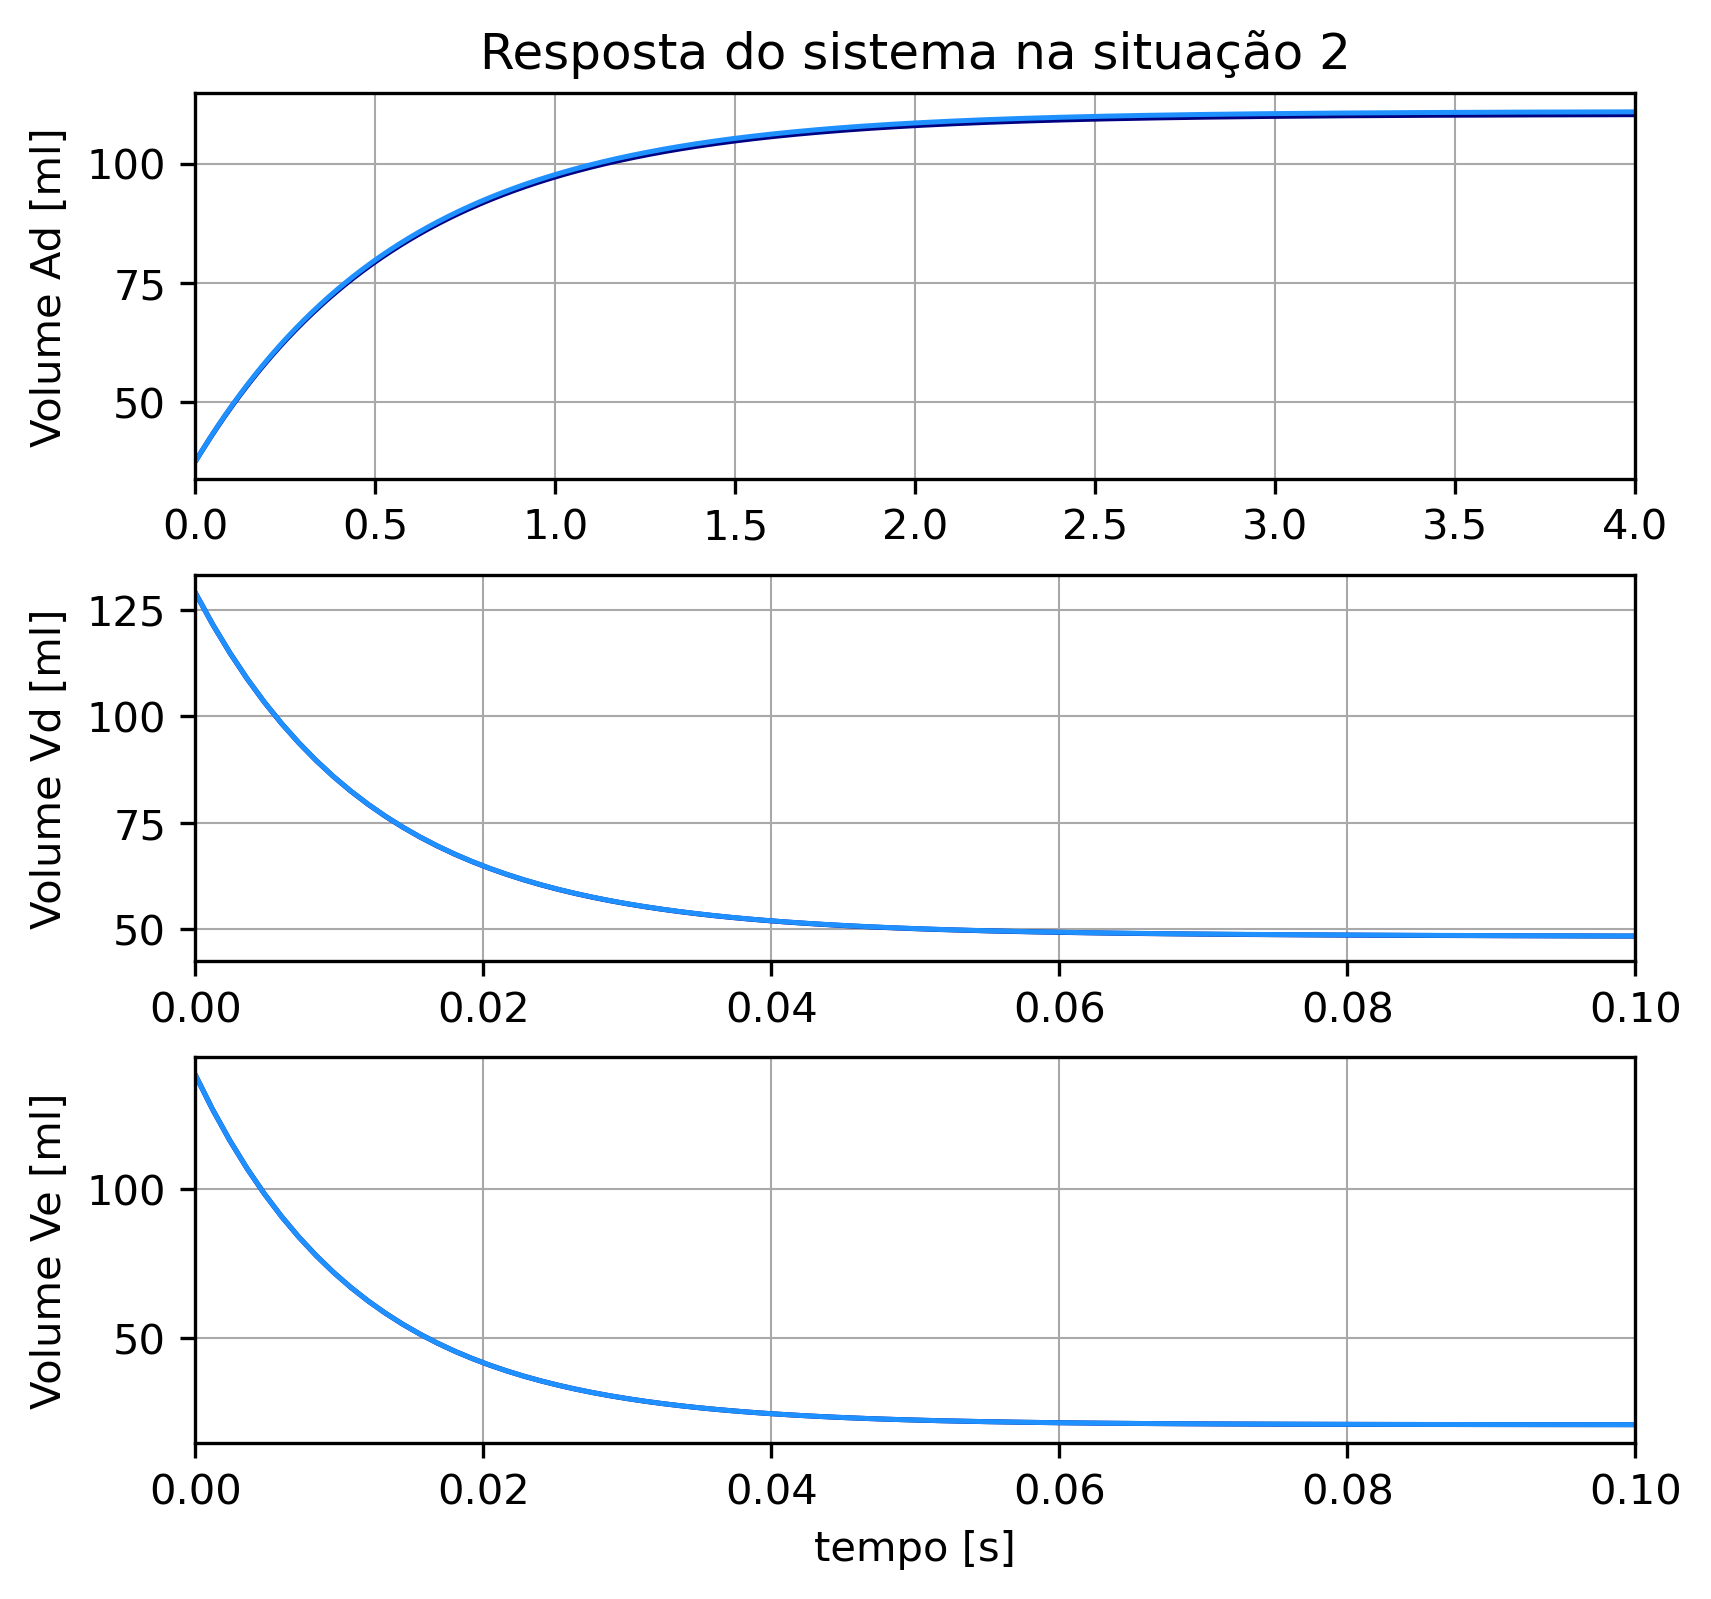

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(t_step, x2[0], 'navy', lw=1.2)
axs[0].plot(t_step, x2_[0], 'dodgerblue', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_ylabel(r'Volume Ad [ml]')
axs[0].set_title(r'Resposta do sistema na situação 2', fontfamily = 'sans-serif', fontsize = 'large')
axs[0].set_xlim(0, 4)

axs[1].plot(t_step, x2[1], 'navy', lw=1.2)
axs[1].plot(t_step, x2_[1], 'dodgerblue', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
axs[1].set_ylabel(r'Volume Vd [ml]')
axs[1].set_xlim(0, 0.1)

axs[2].plot(t_step, x2[3], 'navy', lw=1.2)
axs[2].plot(t_step, x2_[3], 'dodgerblue', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
axs[2].set_xlabel(r'tempo [s]')
axs[2].set_ylabel(r'Volume Ve [ml]')
axs[2].set_xlim(0, 0.1)

# fig.legend(['Sistema em malha aberta', 'Sistema com polos alocados'], loc='center right', shadow=True, fontsize = 9)

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.savefig('step_c2.png', format='png')

plt.show()

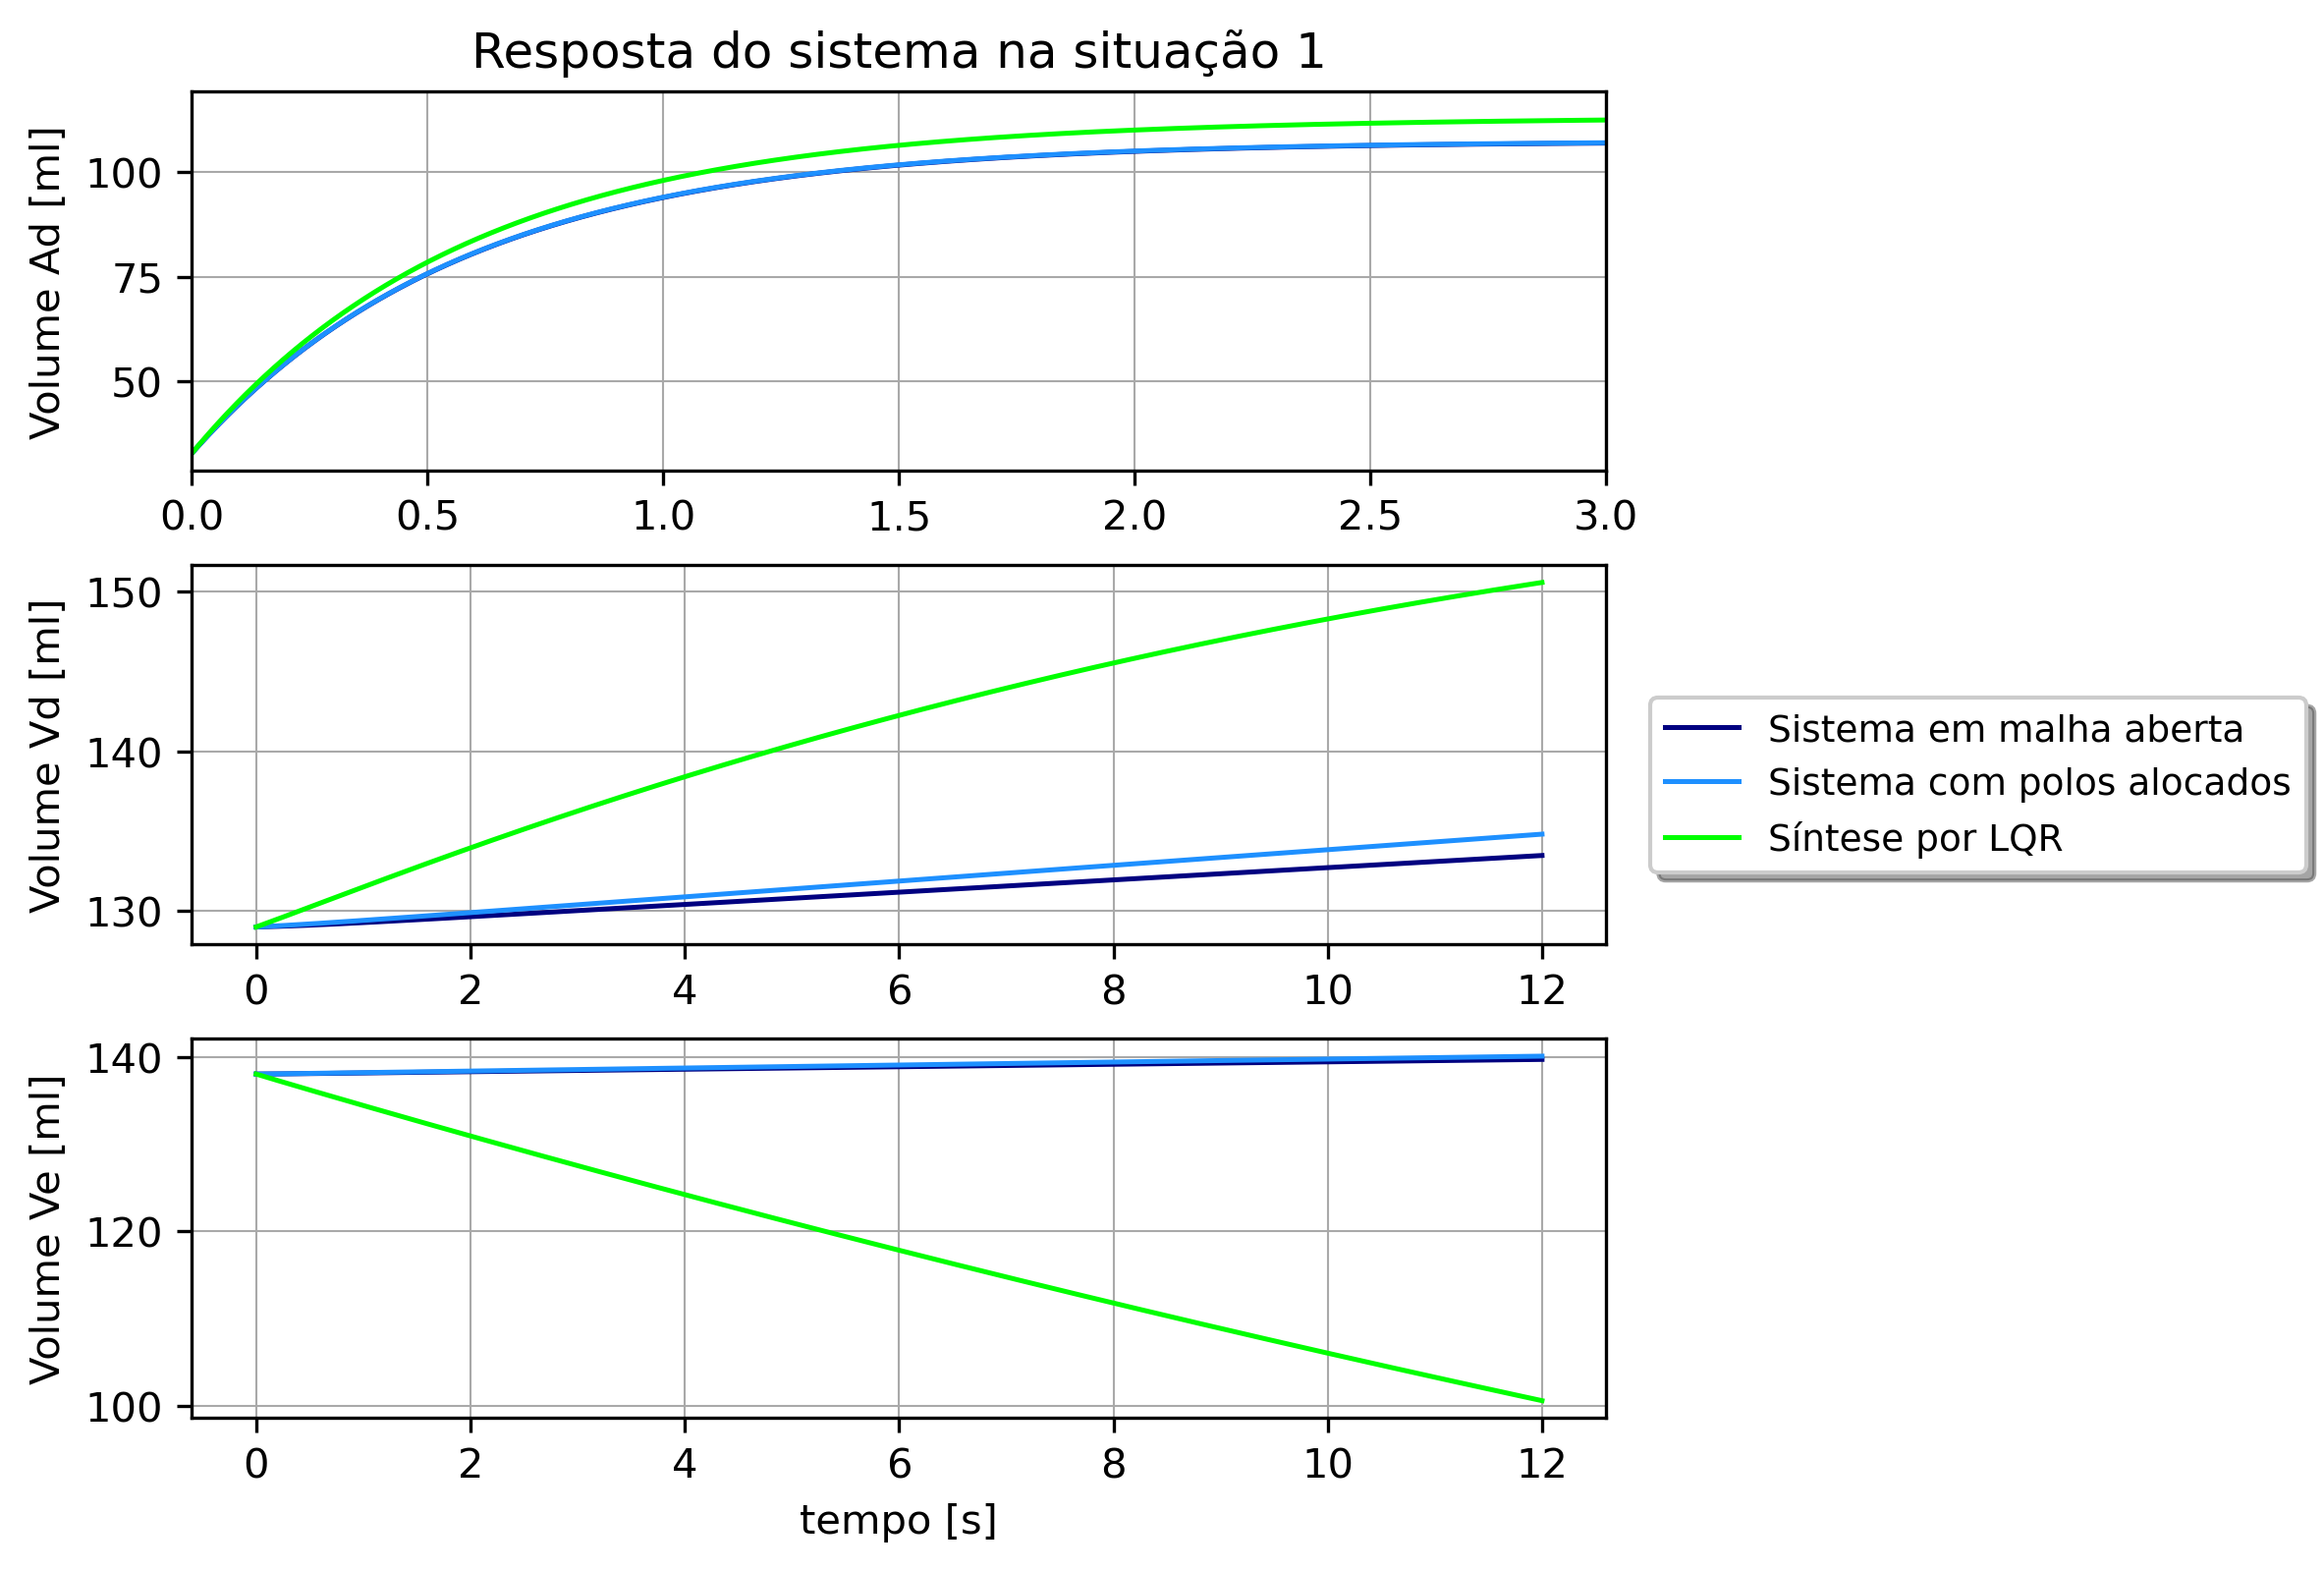

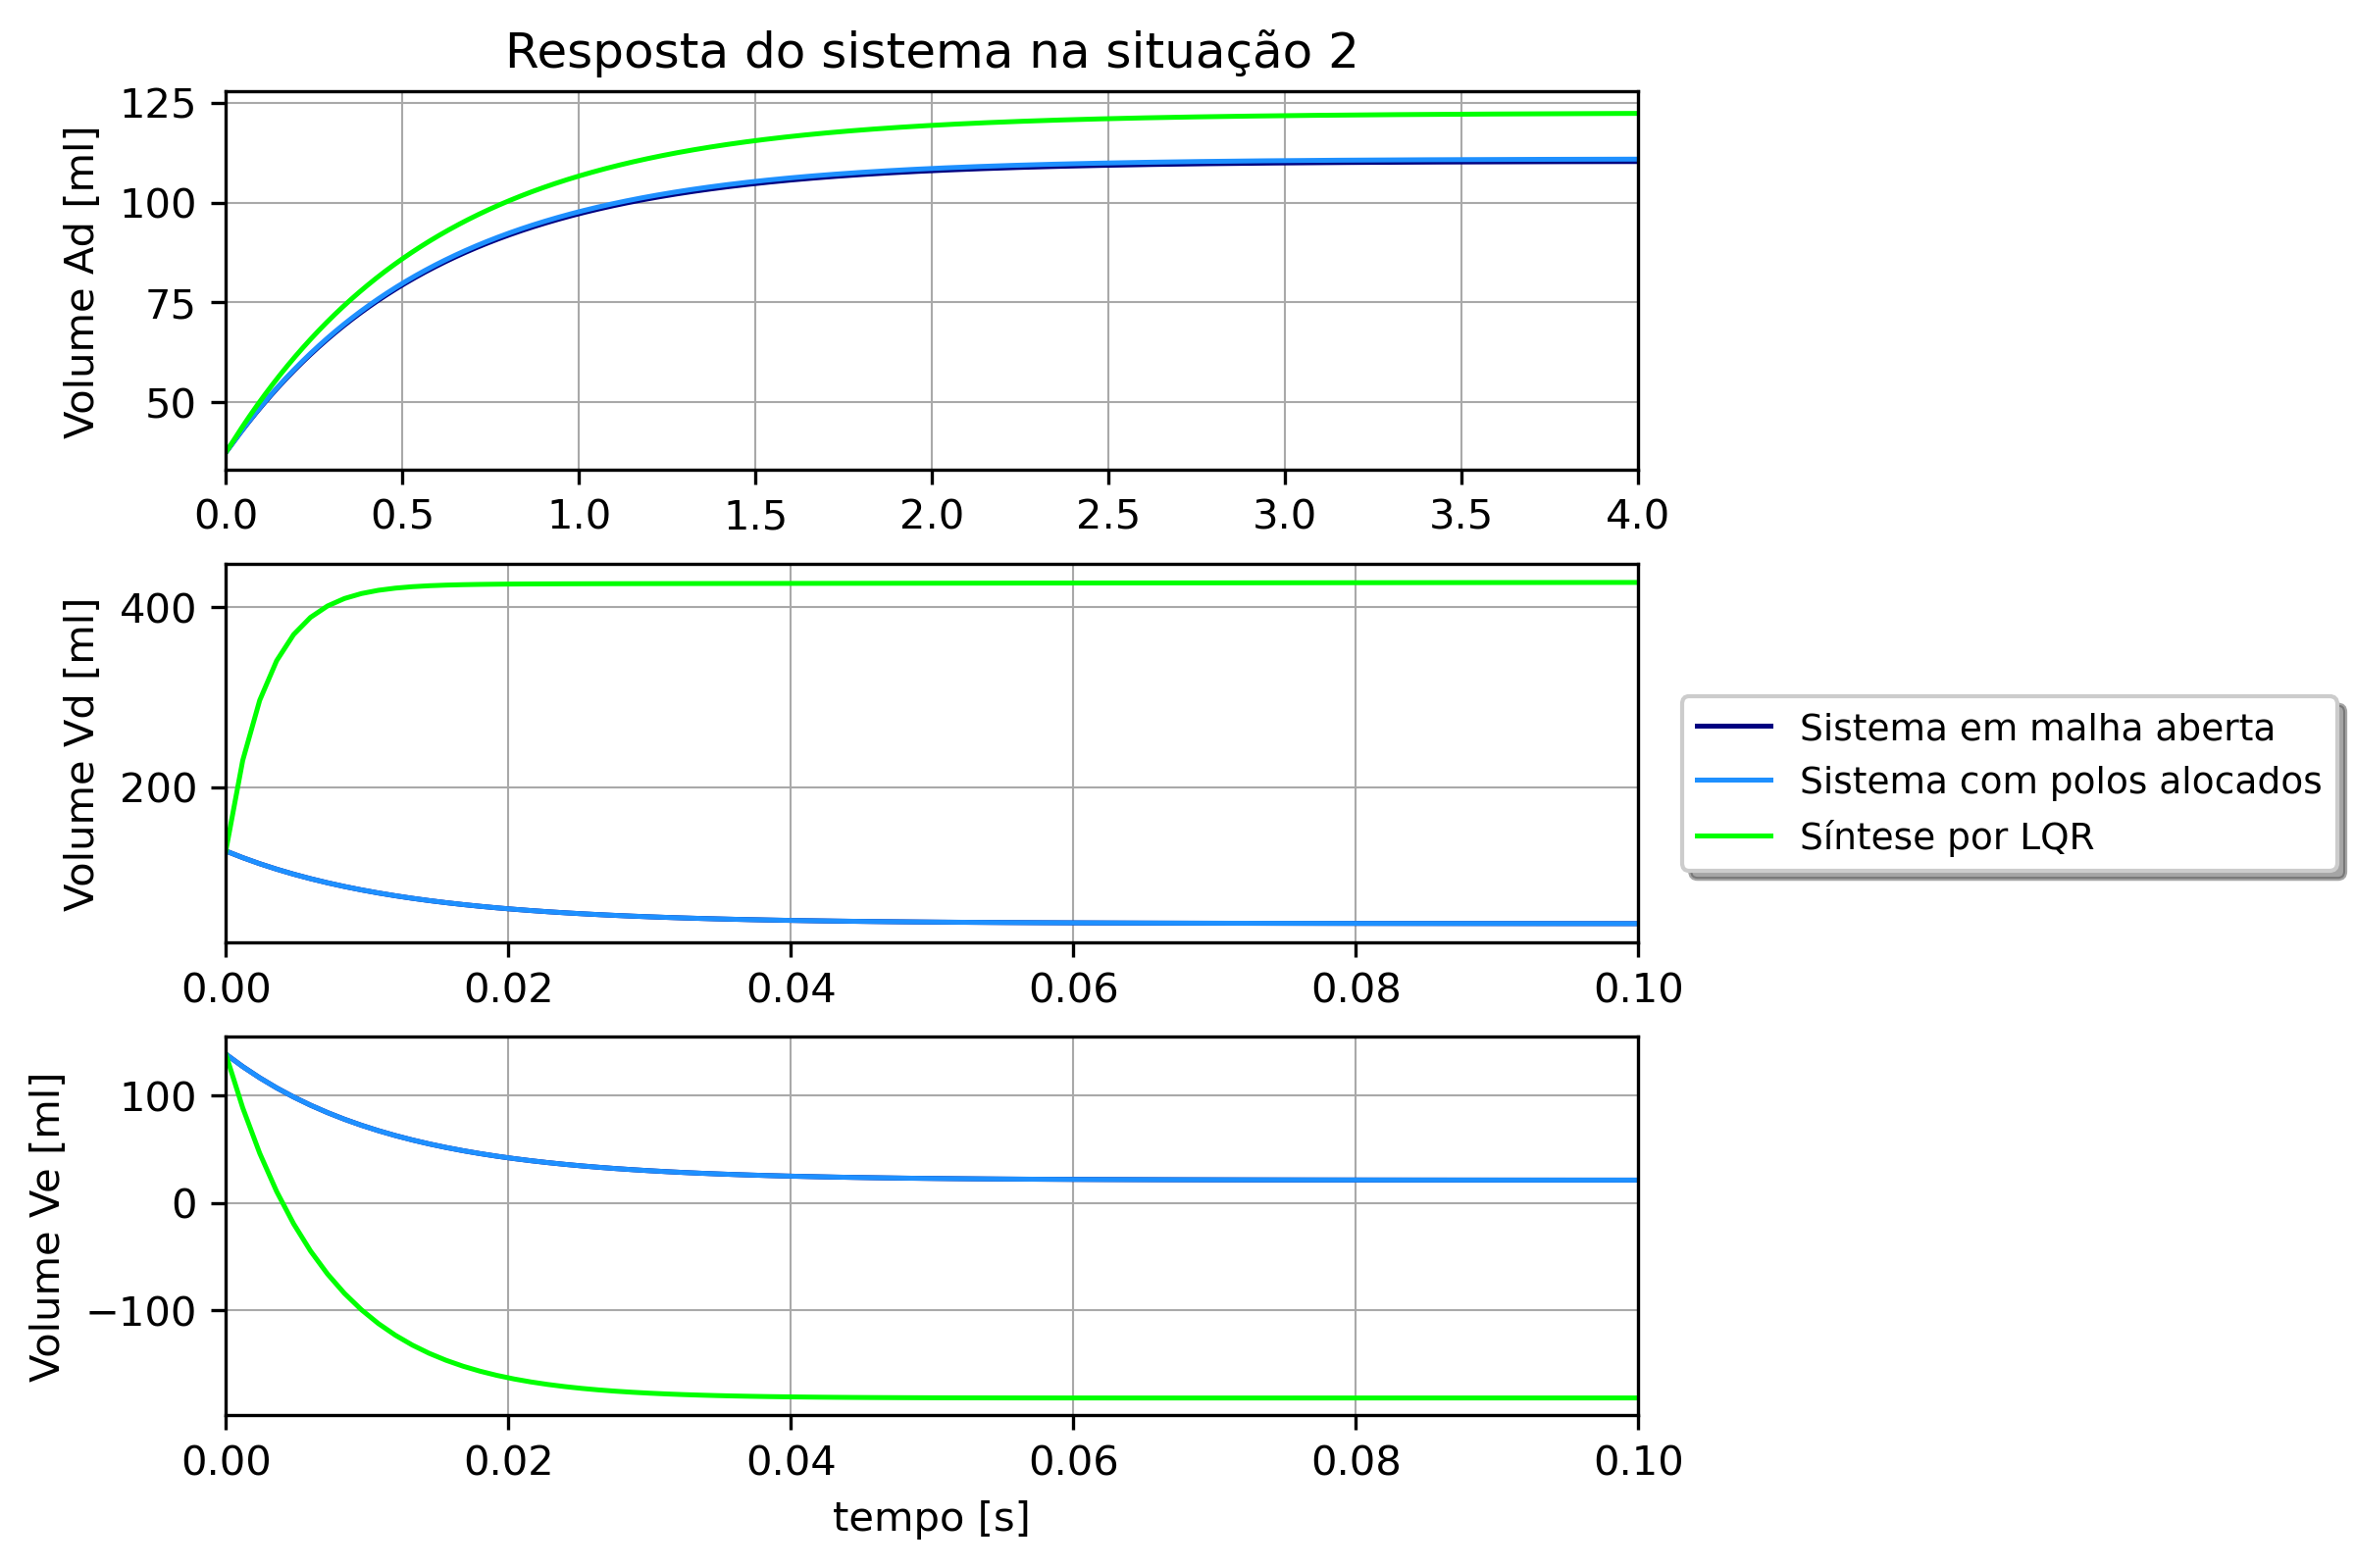

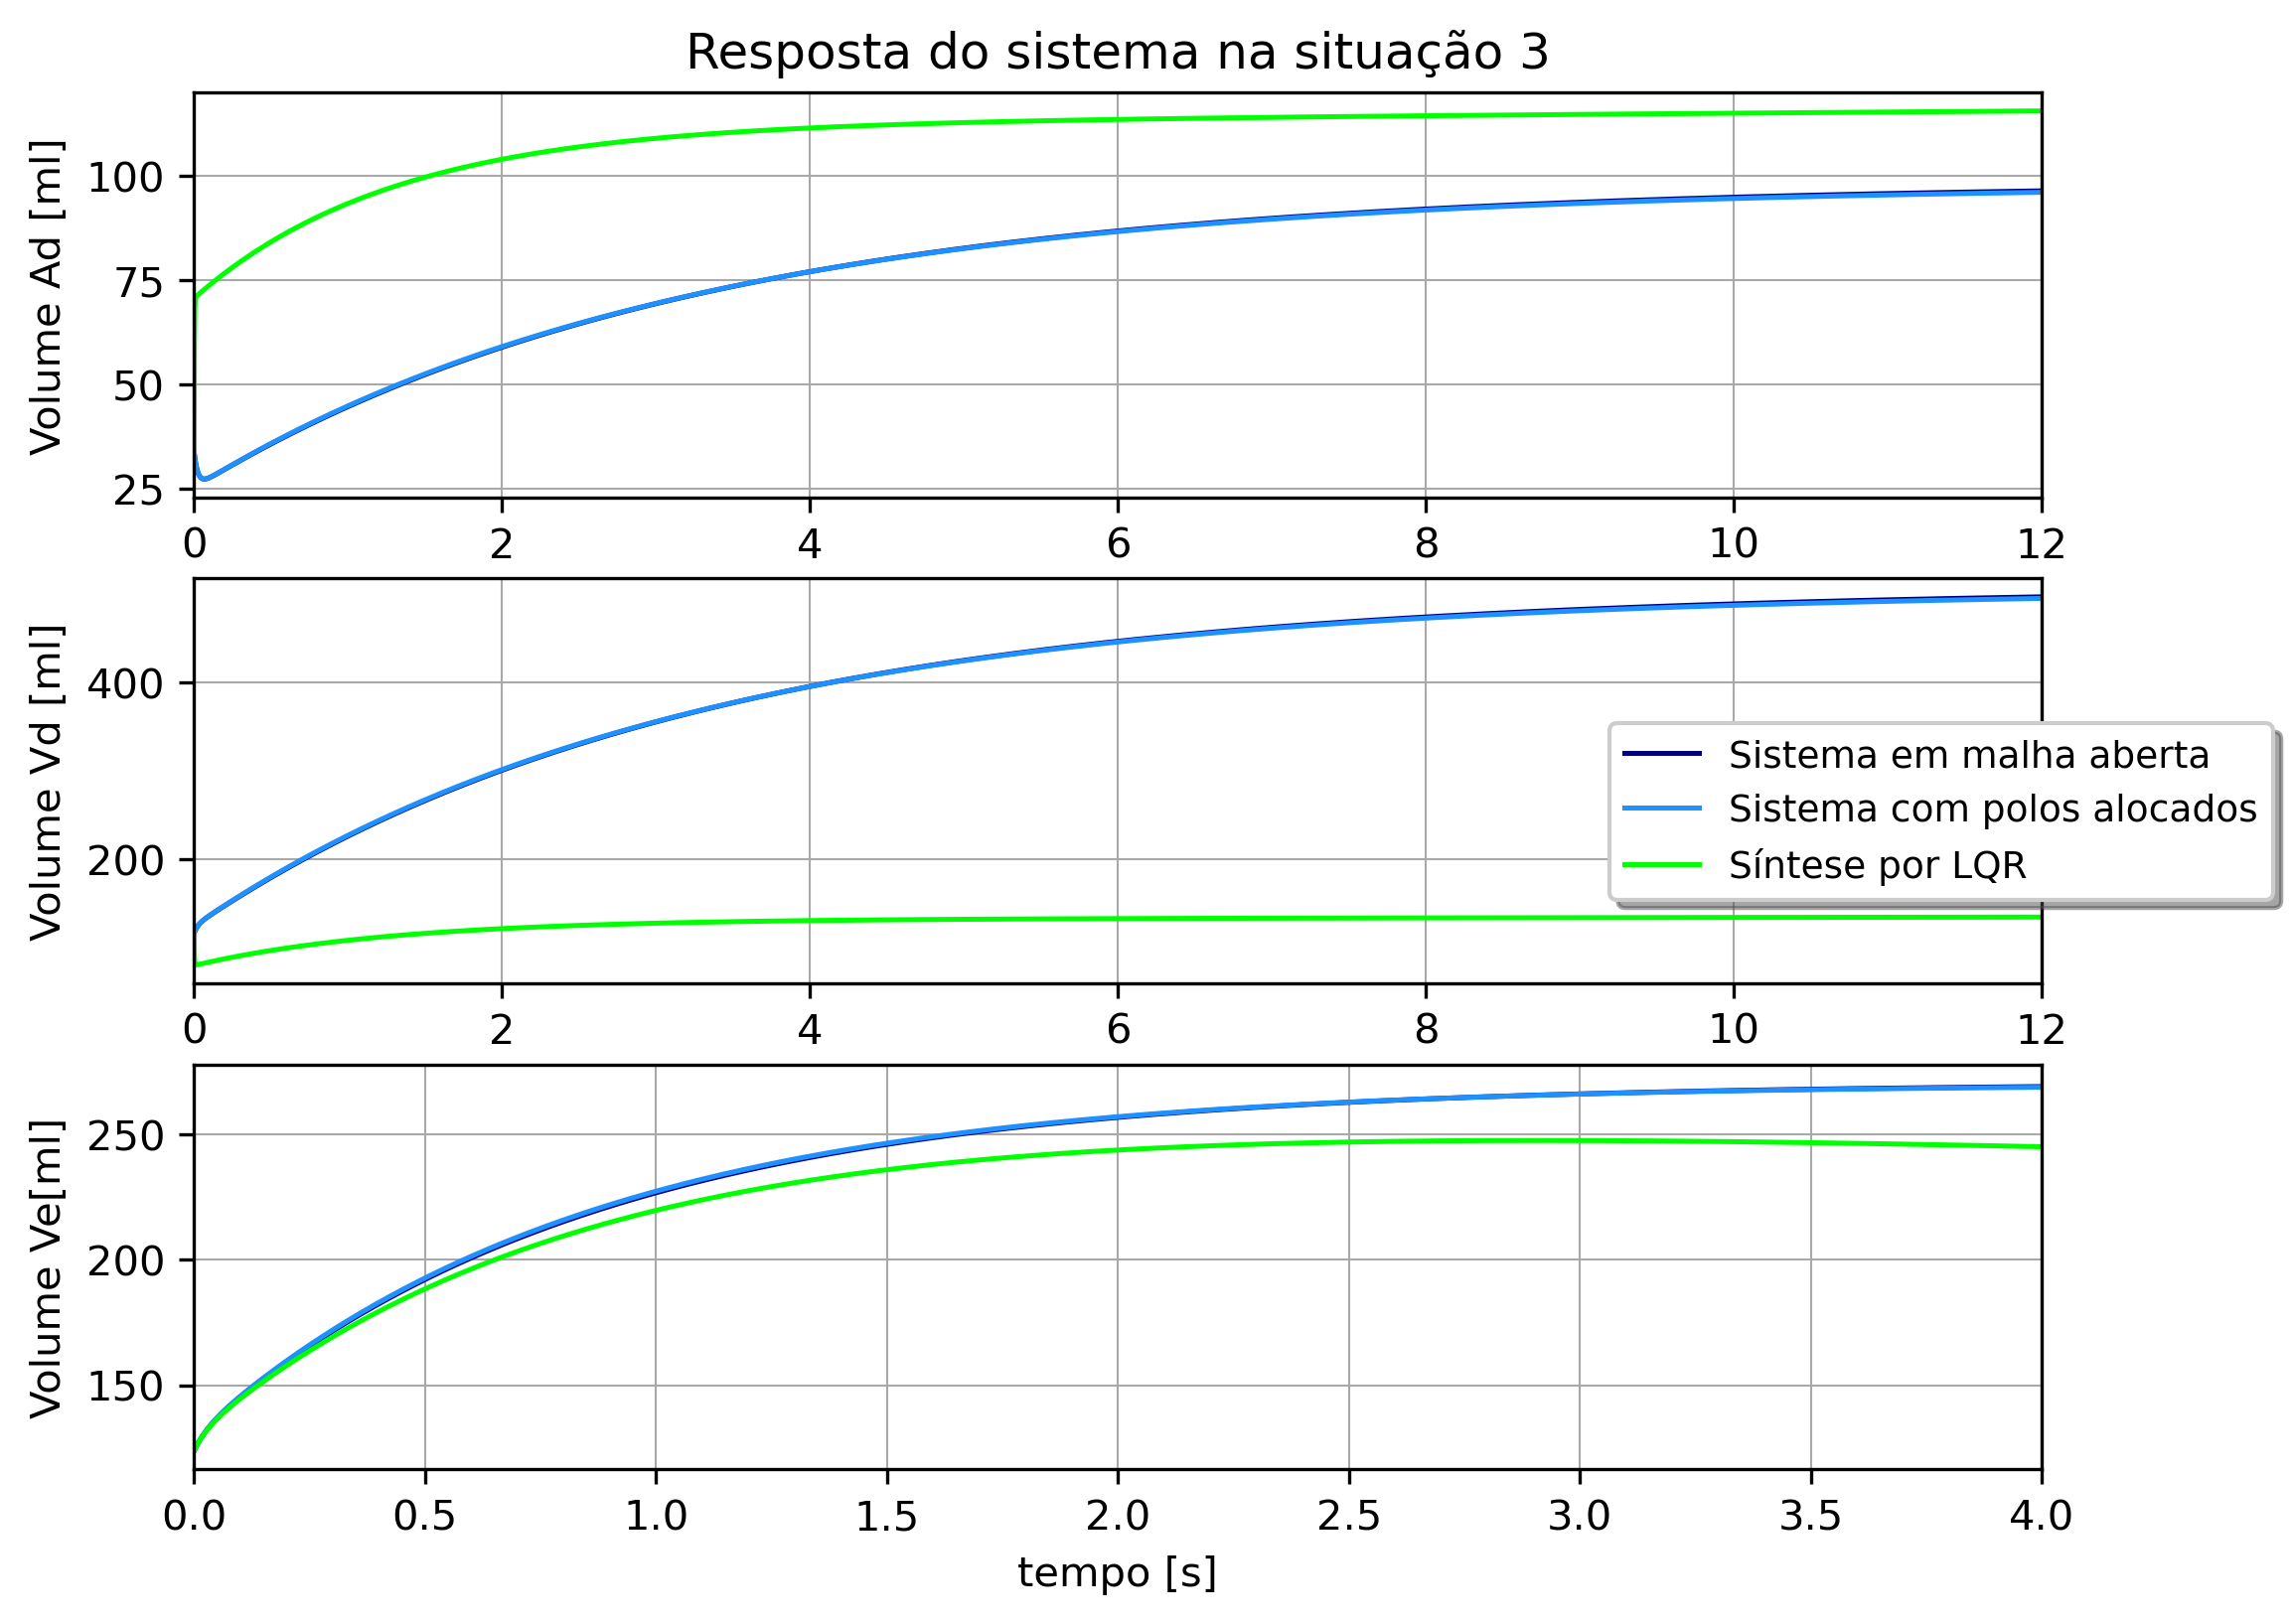

In [11]:
#Síntese do regulador por LQR

Q = 10*np.eye(7)
R = np.eye(3)

K1_LQR, S1, PA1_LQR = clt.lqr(sys1s, Q, R)
A1_LQR = A1d-np.dot(B1d,K1_LQR)
sys1_LQR = clt.ss(A1_LQR,E1,C,D0)

K2_LQR, S2, PA2_LQR = clt.lqr(sys2s, Q, R)
A2_LQR = A2d-np.dot(B2d,K2_LQR)
sys2_LQR = clt.ss(A2_LQR,E2,C,D0)

T1_, out1_, x1_LQR = clt.forced_response(sys1_LQR, T=t_step, X0=X01, U=U1_step, return_x = True)
T2_, out2_, x2_LQR = clt.forced_response(sys2_LQR, T=t_step, X0=X02, U=U1_step, return_x = True)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(t_step, x1[0], 'navy', lw=1.2)
axs[0].plot(t_step, x1_[0], 'dodgerblue', lw=1.2)
axs[0].plot(t_step, x1_LQR[0], 'lime', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_ylabel(r'Volume Ad [ml]')
axs[0].set_title(r'Resposta do sistema na situação 1', fontfamily = 'sans-serif', fontsize = 'large')
axs[0].set_xlim(0, 3)

axs[1].plot(t_step, x1[1], 'navy', lw=1.2)
axs[1].plot(t_step, x1_[1], 'dodgerblue', lw=1.2)
axs[1].plot(t_step, x1_LQR[1], 'lime', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
axs[1].set_ylabel(r'Volume Vd [ml]')
#axs[1].set_xlim(0, 0.0375)

axs[2].plot(t_step, x1[3], 'navy', lw=1.2)
axs[2].plot(t_step, x1_[3], 'dodgerblue', lw=1.2)
axs[2].plot(t_step, x1_LQR[3], 'lime', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
axs[2].set_xlabel(r'tempo [s]')
axs[2].set_ylabel(r'Volume Ve [ml]')
#axs[2].set_xlim(0, 0.0375)

fig.legend(['Sistema em malha aberta', 'Sistema com polos alocados','Síntese por LQR'], loc='center right', shadow=True, fontsize = 9)

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(t_step, x2[0], 'navy', lw=1.2)
axs[0].plot(t_step, x2_[0], 'dodgerblue', lw=1.2)
axs[0].plot(t_step, x2_LQR[0], 'lime', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_ylabel(r'Volume Ad [ml]')
axs[0].set_title(r'Resposta do sistema na situação 2', fontfamily = 'sans-serif', fontsize = 'large')
axs[0].set_xlim(0, 4)

axs[1].plot(t_step, x2[1], 'navy', lw=1.2)
axs[1].plot(t_step, x2_[1], 'dodgerblue', lw=1.2)
axs[1].plot(t_step, x2_LQR[1], 'lime', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
axs[1].set_ylabel(r'Volume Vd [ml]')
axs[1].set_xlim(0, 0.1)

axs[2].plot(t_step, x2[3], 'navy', lw=1.2)
axs[2].plot(t_step, x2_[3], 'dodgerblue', lw=1.2)
axs[2].plot(t_step, x2_LQR[3], 'lime', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
axs[2].set_xlabel(r'tempo [s]')
axs[2].set_ylabel(r'Volume Ve [ml]')
axs[2].set_xlim(0, 0.1)

fig.legend(['Sistema em malha aberta', 'Sistema com polos alocados','Síntese por LQR'], loc='center right', shadow=True, fontsize = 9)

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

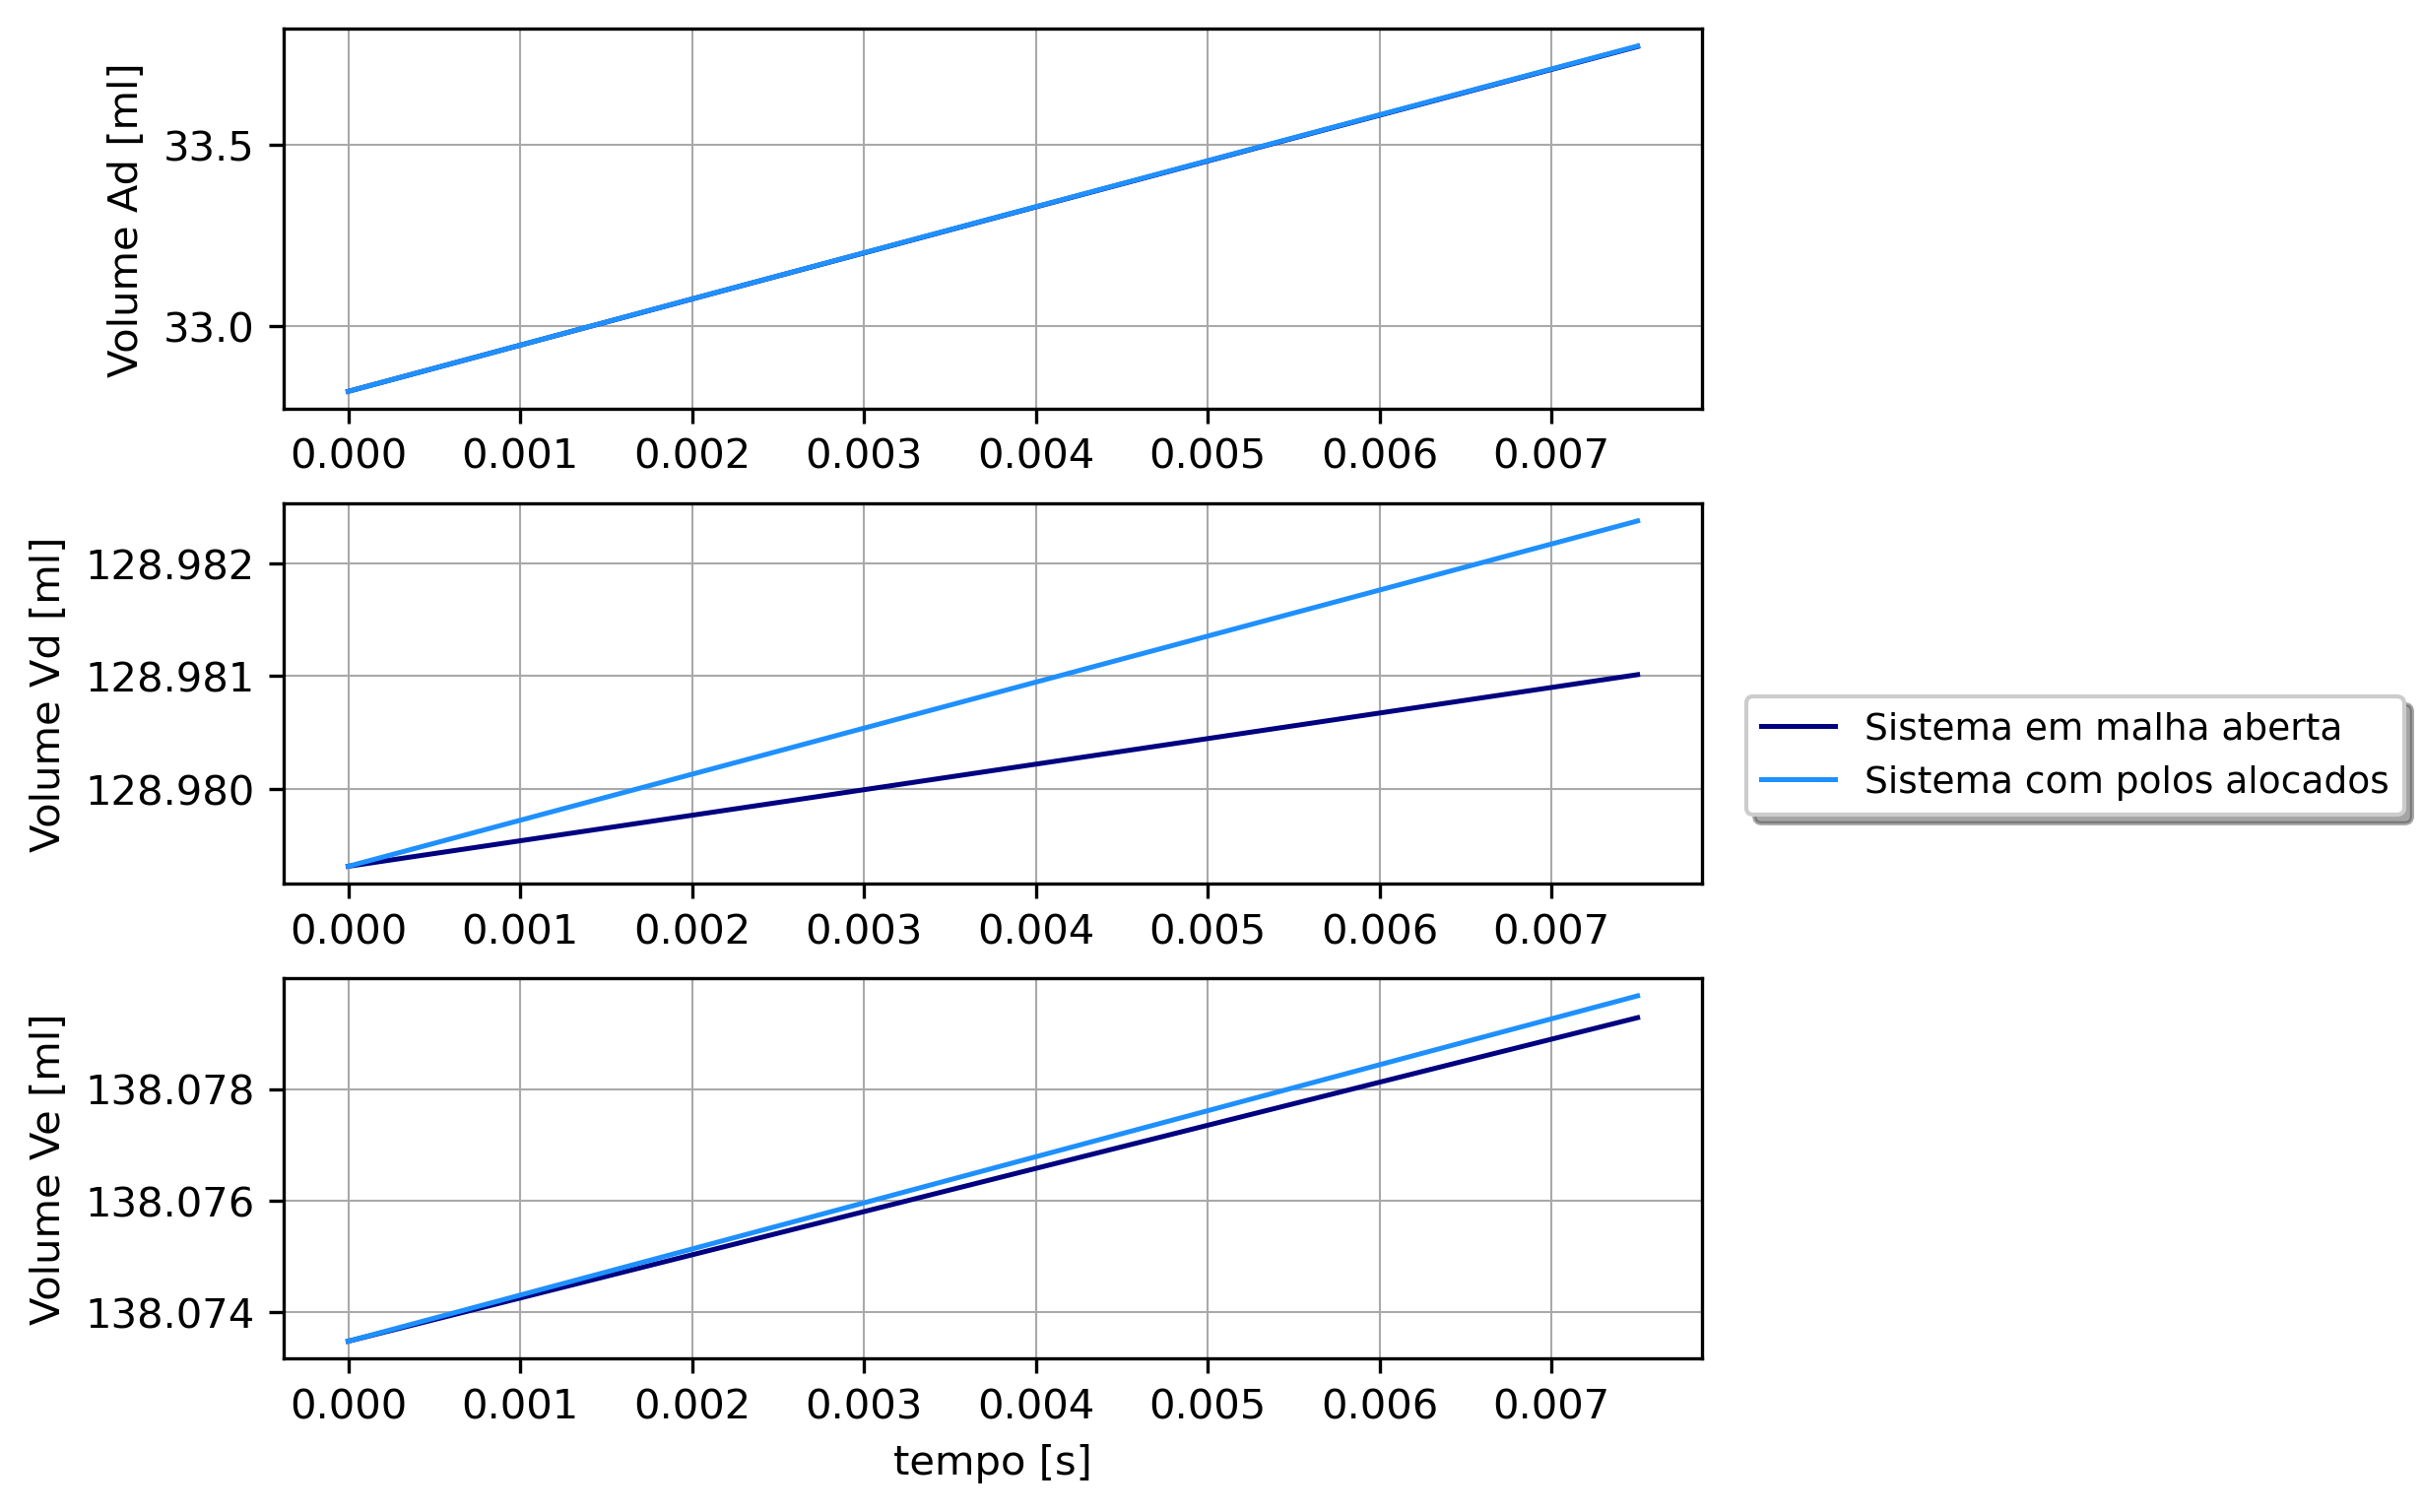

In [21]:
#Simulação inicial - Resposta à entrada de pressões
from matplotlib.ticker import ScalarFormatter
frac1 = 0.05                      #período relativo de contração isovolumétrica
t1 = frac1*tf
steps1 = int(frac1*steps)
int_t1 = np.linspace(0,t1,steps1)

frac2 = 0.15                      #período relativo de ejeção acelerada
t2 = frac2*tf
steps2 = int(frac2*steps)
int_t2 = np.linspace(t1,t2+t1,steps2)

frac3 = 0.12                      #período relativo de enchimento reduzido dos ventrículos
t3 = frac3*tf
steps3 = int(frac3*steps)
int_t3 = np.linspace(tf-t3,tf,steps3)

A1_ = A1-np.dot(B1,K1)
A2_ = A2-np.dot(B2,K2)
A3_ = A3-np.dot(B3,K3)

# Vec_Pvd = np.array([P_v(T, 5, 22, 80) for T in t])
# Vec_Pve = np.array([P_v(T, 10, 120, 80) for T in t])
# Vec_Pad = np.array([P_a(T, 5, 8, 80) for T in t])
# Vec_Pae = np.array([P_a(T, 10, 20, 80) for T in t])
# Vec_Pcp = np.array([P_cp(T, 11, 19, 80) for T in t])
# Vec_Pcs = np.array([P_cs(T, 80, 115, 80) for T in t])

Vec_Pad1 = np.array([P_a(T, 5, 8, 80) for T in int_t1])
Vec_Pvd1 = np.array([P_v(T, 5, 22, 80) for T in int_t1])
Vec_Pcp1 = np.array([P_cp(T, 11, 19, 80) for T in int_t1])
Vec_Pve1 = np.array([P_v(T, 10, 120, 80) for T in int_t1])
Vec_Pcs1 = np.array([P_cs(T, 80, 115, 80) for T in int_t1])
Vec_Pad2 = np.array([P_a(T, 5, 8, 80) for T in int_t2])
Vec_Pvd2 = np.array([P_v(T, 5, 22, 80) for T in int_t2])
Vec_Pcp2 = np.array([P_cp(T, 11, 19, 80) for T in int_t2])
Vec_Pve2 = np.array([P_v(T, 10, 120, 80) for T in int_t2])
Vec_Pcs2 = np.array([P_cs(T, 80, 115, 80) for T in int_t2])
Vec_Pad3 = np.array([P_a(T, 5, 8, 80) for T in int_t3])
Vec_Pvd3 = np.array([P_v(T, 5, 22, 80) for T in int_t3])
Vec_Pcp3 = np.array([P_cp(T, 11, 19, 80) for T in int_t3])
Vec_Pve3 = np.array([P_v(T, 10, 120, 80) for T in int_t3])
Vec_Pcs3 = np.array([P_cs(T, 80, 115, 80) for T in int_t3])

Delta_Pad1 = Vec_Pad1 - Vec_Pvd1
Delta_Pvd1 = Vec_Pvd1 - Vec_Pcp1
Delta_Pve1 = Vec_Pve1 - Vec_Pcs1
Delta_Pad2 = Vec_Pad2 - Vec_Pvd2
Delta_Pvd2 = Vec_Pvd2 - Vec_Pcp2
Delta_Pve2 = Vec_Pve2 - Vec_Pcs2
Delta_Pad3 = Vec_Pad3 - Vec_Pvd3
Delta_Pvd3 = Vec_Pvd3 - Vec_Pcp3
Delta_Pve3 = Vec_Pve3 - Vec_Pcs3

U1_real = [Delta_Pad1, Delta_Pvd1, Delta_Pve1, q0*np.ones(steps1)]
U2_real = [Delta_Pad2, Delta_Pvd2, Delta_Pve2, q0*np.ones(steps2)]
U3_real = [Delta_Pad3, Delta_Pvd3, Delta_Pve3, q0*np.ones(steps3)]

#X01 = [32.8208014 ,  128.97931383,   39.65605596,  138.07347741, 687.11288571, -145.94694028, -127.52152711]
X01_ = X01

T1, out1, x1 = clt.forced_response(sys1, T=int_t1, X0=X01, U=U1_real, return_x = True)
T1_, out1_, x1_ = clt.forced_response(sys1_, T=int_t1, X0=X01_, U=U1_real, return_x = True)

#X02 = x1[:,steps1-1]
#X02_ = x1_[:,steps1-1]

T2, out2, x2 = clt.forced_response(sys2, T=int_t2, X0=X02, U=U2_real, return_x = True)
T2_, out2_, x2_ = clt.forced_response(sys2_, T=int_t2, X0=X02_, U=U2_real, return_x = True)

#X03 = [33.9064531 ,  116.14747051,   39.99517533,  123.84961663, 700.88055257, -150.63347473, -126.1929136 ]
X03_ = X03

T3, out3, x3 = clt.forced_response(sys3, T=int_t3, X0=X03, U=U3_real, return_x = True)
T3_, out3_, x3_ = clt.forced_response(sys3_, T=int_t3, X0=X03_, U=U3_real, return_x = True)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(int_t1, x1[0], 'navy', lw=1.2)
axs[0].plot(int_t1, x1_[0], 'dodgerblue', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
axs[0].set_ylabel(r'Volume Ad [ml]')
#axs[0].set_xscale('symlog')
# axs[0].legend(['Vad', 'Vad_'], loc='lower right', shadow=False)
# axs[0].set_title(r'Resposta do sistema na situação 1', fontfamily = 'sans-serif', fontsize = 'large')
#axs[0].set_xlim(0, 0.0375)

axs[1].plot(int_t1, x1[1], 'navy', lw=1.2)
axs[1].plot(int_t1, x1_[1], 'dodgerblue', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
axs[1].set_ylabel(r'Volume Vd [ml]')
#axs[1].set_xscale('symlog')
# axs[1].legend(['Vvd', 'Vvd_'], loc='lower right', shadow=False)
axs[1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axs[2].plot(int_t1, x1[3], 'navy', lw=1.2)
axs[2].plot(int_t1, x1_[3], 'dodgerblue', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
axs[2].set_ylabel(r'Volume Ve [ml]')
axs[2].set_xlabel(r'tempo [s]')
#axs[2].set_xscale('symlog')
# axs[2].legend(['Vve', 'Vve_'], loc='lower right', shadow=False)
#axs[2].set_xlim(0, 0.0375)
axs[2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

fig.legend(['Sistema em malha aberta', 'Sistema com polos alocados'], loc='center right', shadow=True, fontsize = 9)
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
      
plt.show()

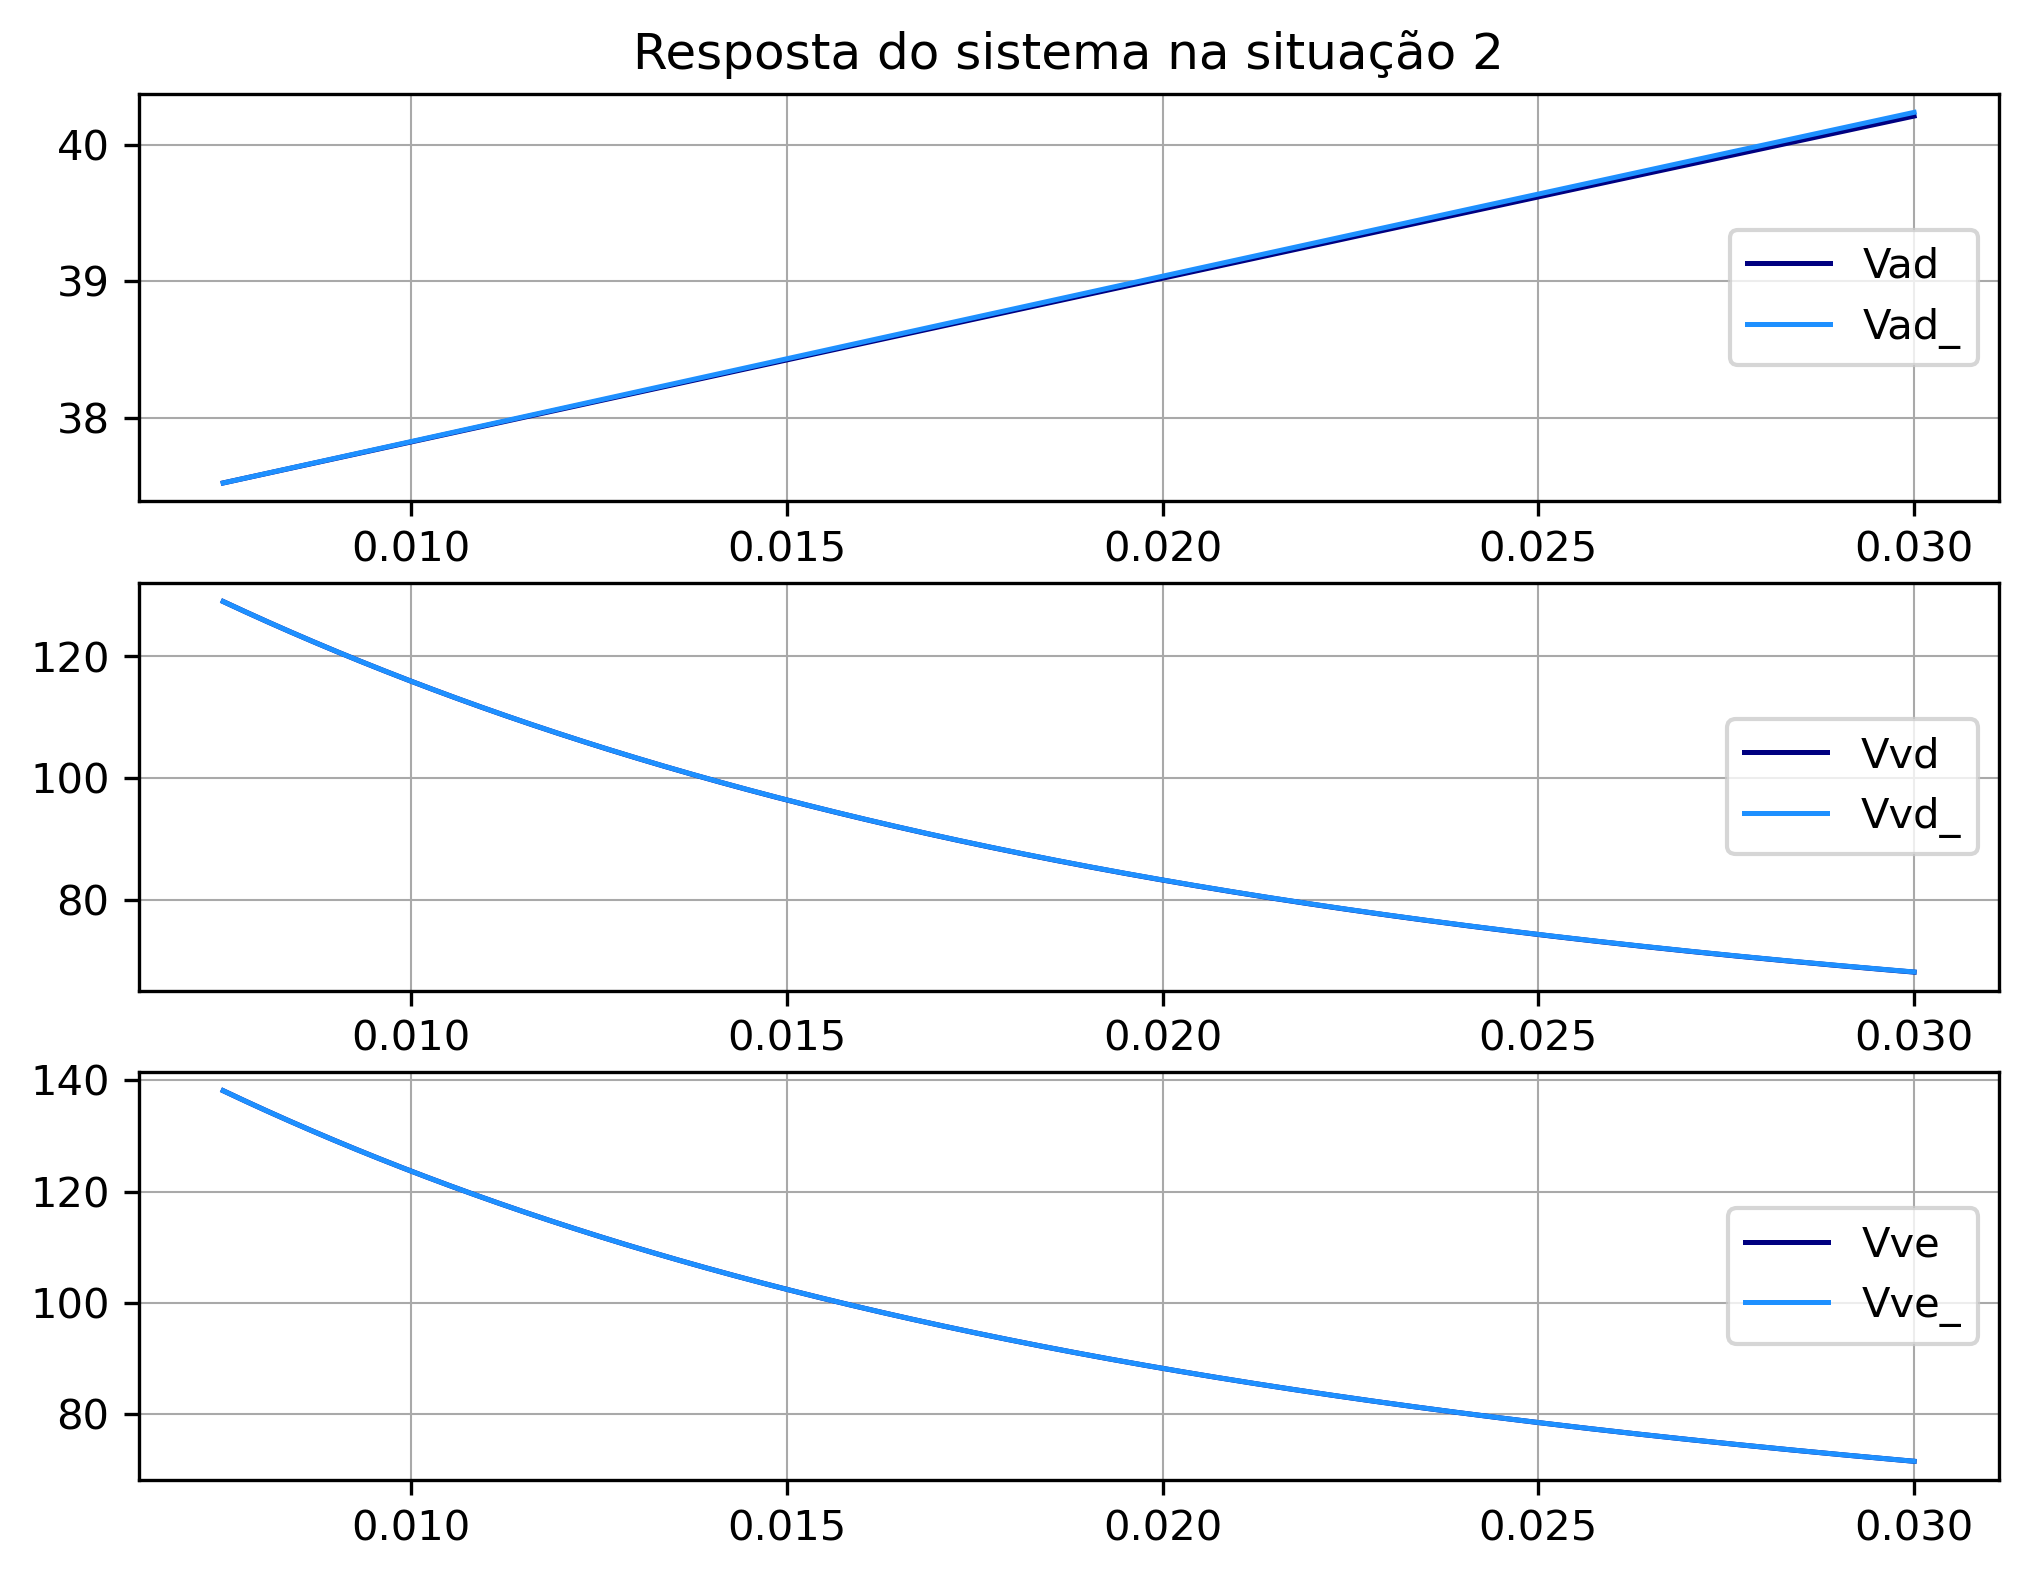

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), dpi=300)

axs[0].plot(int_t2, x2[0], 'navy', lw=1.2)
axs[0].plot(int_t2, x2_[0], 'dodgerblue', lw=1.2)
axs[0].grid(color='darkgrey', lw=0.5)
#axs[0].set_xscale('symlog')
axs[0].legend(['Vad', 'Vad_'], loc='center right', shadow=False)
axs[0].set_title(r'Resposta do sistema na situação 2', fontfamily = 'sans-serif', fontsize = 'large')
#axs[0].set_xlim(0.0375, 0.15)
#axs[0].set_ylim(0, 15)

axs[1].plot(int_t2, x2[1], 'navy', lw=1.2)
axs[1].plot(int_t2, x2_[1], 'dodgerblue', lw=1.2)
axs[1].grid(color='darkgrey', lw=0.5)
#axs[1].set_xscale('symlog')
axs[1].legend(['Vvd', 'Vvd_'], loc='center right', shadow=False)
#axs[1].set_xlim(0.0375, 0.15)
#axs[1].set_ylim(-10, 15)

axs[2].plot(int_t2, x2[3], 'navy', lw=1.2)
axs[2].plot(int_t2, x2_[3], 'dodgerblue', lw=1.2)
axs[2].grid(color='darkgrey', lw=0.5)
#axs[2].set_xscale('symlog')
axs[2].legend(['Vve', 'Vve_'], loc='center right', shadow=False)
#axs[2].set_xlim(0.0375, 0.15)
#axs[2].set_ylim(-25, 25)

plt.show()

In [ ]:
# Síntese de observador por alocação de polos

L1 = sci.signal.place_poles(A1d.transpose(),C.transpose(),5*P1,method='YT').gain_matrix
L2 = sci.signal.place_poles(A2d.transpose(),C.transpose(),5*P2,method='YT').gain_matrix
L3 = sci.signal.place_poles(A3.transpose(),C.transpose(),5*P3,method='YT').gain_matrix

A1c = A1d-np.dot(L1,C)
A2c = A3-np.dot(L2,C)